# Imports and Constants

## Libraries and Imports (Dependencies)

In [19]:
import re
import os
import glob
import string
import warnings
import joblib
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
sns.set_style("darkgrid")

from matplotlib import cm
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict

import scipy.cluster.hierarchy as shc

from IPython.display import Image

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import gensim
from gensim import corpora
from gensim.models import LdaModel, LsiModel, TfidfModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, strip_short, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string

from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, randomized_svd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

import locale

In [20]:
import warnings
warnings.filterwarnings("ignore")

## Utility Functions and Constants

In [21]:
#
# Constants
#  
COLAB = False

NUM_TOPICS = 5
NUM_WORDS = 11

#
# check if we're running Google Colab or not
#
if (COLAB):
  DATA_DIR = '/content/drive/MyDrive/google_colab/NLP/Topic Modeling/data/'
  IMG_DIR = DATA_DIR + '../img/'
  OUT_DIR = DATA_DIR + '../output/'

  import google
  google.colab.drive.mount('/content/drive', force_remount=True)

else:
  DATA_DIR = '/Users/peter/My Drive/FAU/Natural Language Processing (CAP6640)/code/data/'
  IMG_DIR = DATA_DIR + '../../Topic Modeling/img/'
  OUT_DIR = DATA_DIR + '../../Topic Modeling/output/'

DIR = DATA_DIR + '/chapter_docs/'
FILE_DIR = DIR 

In [22]:
def get_chapters_from_files(directory):

  #print("...get_chapters_from_files(directory: " + directory + ")...")
  
  chapters = defaultdict(str)
  
  for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
  
    if file.endswith(".txt") and os.path.getsize(file_path) > 0:
  
      #print("processing chapter: " + file + "...")
  
      file_name_tuple = os.path.splitext(file)
      file_name_wo_ext = file_name_tuple[0]

      with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        chapters[file_name_wo_ext] = text
  
  return chapters


# Custom filter methods
transform_to_lower = lambda s: s.lower()
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

# Filters to be executed in pipeline
CLEAN_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char]

def preprocess_text_gensim(text):
  #print("...preprocess_text()...")  
  return [word.lower() for word in preprocess_string(text, CLEAN_FILTERS) if word not in STOPWORDS]

In [23]:
def write_cluster_info(num_topics=NUM_TOPICS, num_features=NUM_WORDS, filename='output', vector=None, km=None):

  feature_names = vector.get_feature_names_out()

  dt_str = datetime.now().strftime("%m%d%Y")

  ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

  file = open(OUT_DIR + filename + '_' + dt_str + '.txt', 'w+', encoding='utf-8')

  for cluster in range(num_topics):
  
    out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
    print(out_str)
    file.write(out_str + '\n')
    
    key_features = [feature_names[index] 
                    for index in ordered_centroids[cluster, :num_features]]
    
    print('Key Features:', key_features)
    file.write('Key Features (terms): ')
    for feat in key_features:
      file.write(feat + ' ')

    file.write('\n')

    out_str = 'Chapters:'
    print(out_str)
    file.write(out_str + '\n')

    label_index = 0

    for x in km.labels_:
      if (x == cluster):
        out_str = str(label_index) + ": " + chap_titles[label_index] 
        print(out_str)
        file.write(out_str + '\n')
      label_index +=1
    
    out_str = '-'*140 
    print(out_str, '\n')
    file.write(out_str + '\n\n')

  file.close()

In [24]:
# 
# chatGPT wrote (most of) this
#
def split_file(input_filename, output_directory):

    # Open the input file and read its contents
    with open(input_filename, 'r', encoding='utf-8') as input_file:
        contents = input_file.read()

    # Split the contents into chunks based on the separator criteria
    chunks = contents.split('\n\n\n\n')             # empty lines in the text

    ch_cnt = 0

    # Create an output file for each chunk
    for i, chunk in enumerate(chunks):
        # Skip empty chunks
        if not chunk.strip():
            continue

        # Extract the title and content from the chunk
        lines = chunk.strip().split('\n')
        title = lines[0]
        content = '\n'.join(lines[1:])

        print("processing CH" + str(ch_cnt) + ": " + title + "...")

        # Create the output file
        output_filename = os.path.join(output_directory, f'{ch_cnt+1}{"_"}{title}.txt')
        with open(output_filename, 'w+', encoding='utf-8') as output_file:
            output_file.write(content)

        ch_cnt += 1
        

# Data Load and Prep

## Split Chapters

In [25]:
#
# run this just once to split the main file into chapters
#

input_filename = DATA_DIR + 'theology_reconsidered (clean) copy.txt'
output_directory = DATA_DIR + 'chapter_docs/'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

split_file(input_filename, output_directory)

processing CH0: Introduction...
processing CH1: Prologue: Mythos and Mysticism in Antiquity...
processing CH2: A Brief History of the Mystical Arts: Beyond Yoga...
processing CH3: Meditation as a Mystical Art: A Bridge Through Time ...
processing CH4: Overarching Themes: The Laurasian Hypothesis and a New Metaphysics...
processing CH5: Setting the Stage: A Brief of History of Modern Man...
processing CH6: Part I: On Creation Mythos (Cosmogony)...
processing CH7: From Language to Writing: The Dawn of History...
processing CH8: The Ancient Hebrews: The Tanakh, Torah and Five Books of Moses...
processing CH9: Ancient Egyptian Mythos: The Weighing of the Heart, Ra and Ma'at...
processing CH10: The Enûma Eliš: Sumer- Babylonian Creation Mythos...
processing CH11: Ancient Persian Theology: Zarathustra and the Avesta...
processing CH12: Classic Hellenic Theogony: Chaos, Chronos and Eros...
processing CH13: Orphic Theogony: Thanes and the Great Cosmic Egg...
processing CH14: Vedic Cosmogony: S

## Load Chapters

In [26]:
locale.getpreferredencoding()

'UTF-8'

In [27]:
# read the chapters from disk
chapters = get_chapters_from_files(DIR)
len(chapters)

52

In [28]:
chaps = list(chapters.values())

chap_titles = list(chapters)

## WordCloud Visualization by Chapter

We walk through each Chapter here and print top 20 words (by frequency) and then build WordCloud visualizations for each

Top 20 words in 39_The Age of Enlightenment: The Philosophy of Science: ['God', 'work', 'philosophy', 'science', 'knowledge', 'one', 'law', 'reason', 'universe', 'philosopher', 'Newton', 'development', 'intellectual', 'first', 'Spinoza', 'world', 'modern', 'upon', 'well', 'Descartes']
Top 20 words in 46_Interpretations of Quantum Theory: Physics Meets Philosophy: ['Quantum Theory', 'one', 'reality', 'interpretation', 'e', 'underlying', 'system', 'notion', 'Theory', 'Quantum Mechanics', 'fact', 'existence', 'Quantum', 'Physics', 'Bohm', 'model', 'assumption', 'measurement', 'physical', 'must']
Top 20 words in 50_Vedic Theology: Vedānta and Brahmavidyā: ['Vedānta', 'Brahman', 'Vedas', 'e', 'ancient', 'theo philosophical', 'Indo Aryan', 'tradition', 'Upanishad', 'nature', 'existence', 'fact', 'well', 'Hindu', 'Soul', 'one', 'Vedic', 'Sanskrit', 'knowledge', 'school']
Top 20 words in 3_A Brief History of the Mystical Arts: Beyond Yoga: ['ancient', 'people', 'technique', 'well', 'theo philo

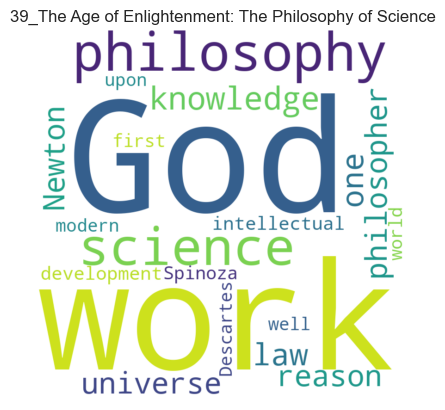

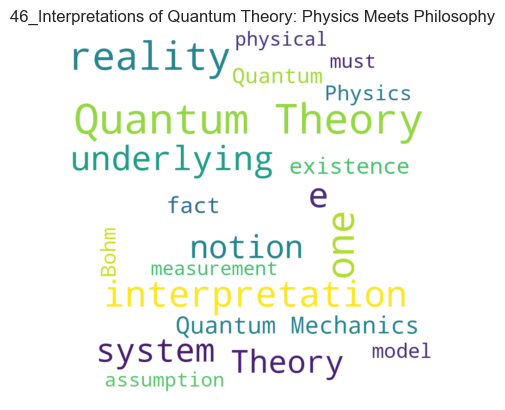

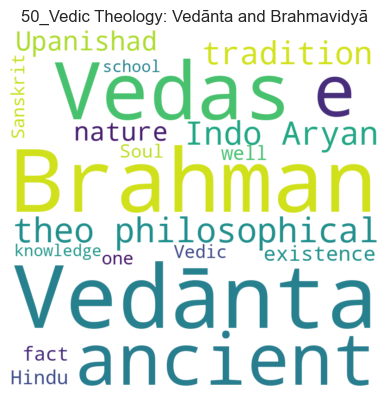

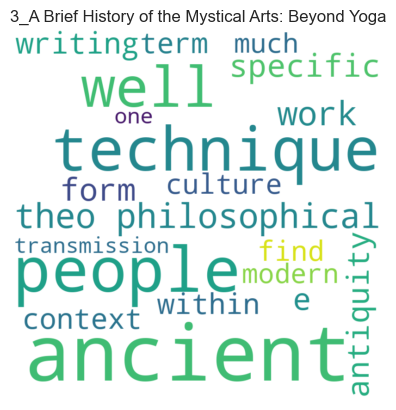

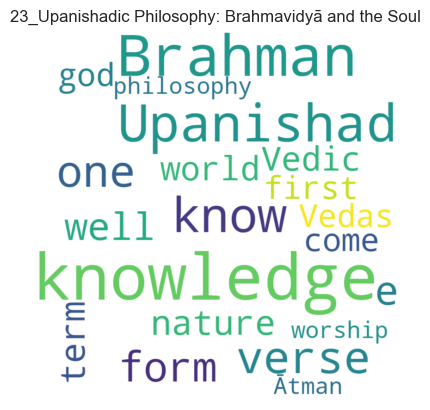

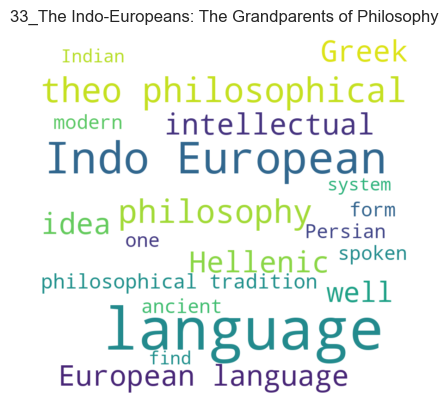

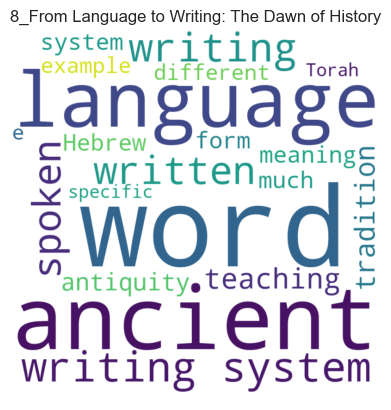

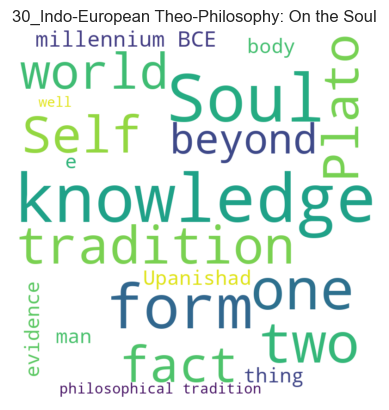

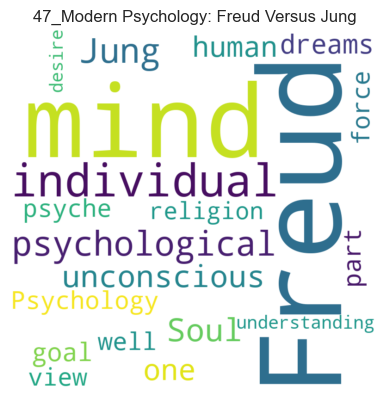

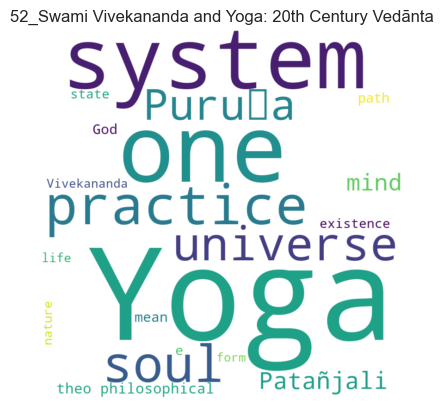

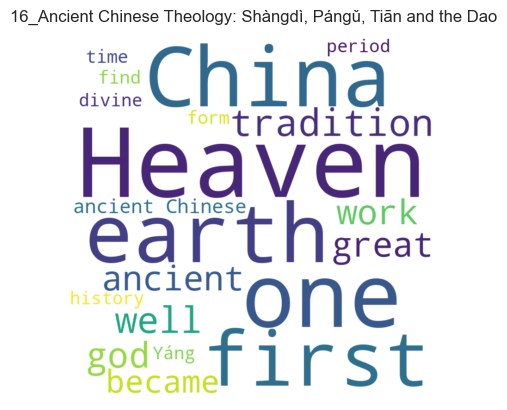

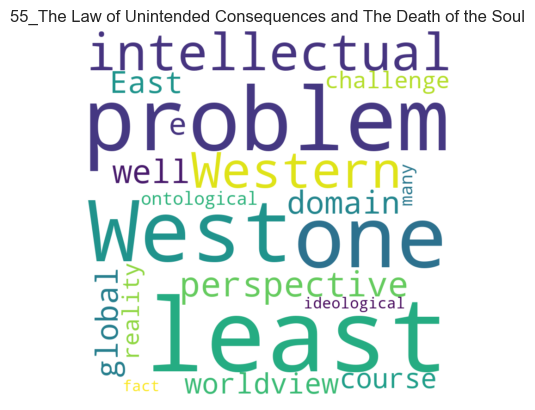

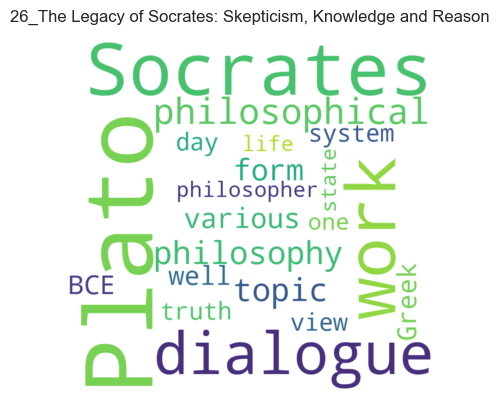

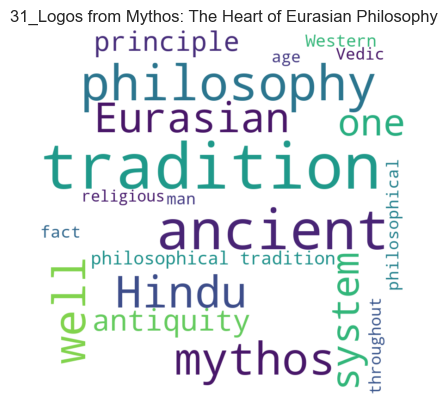

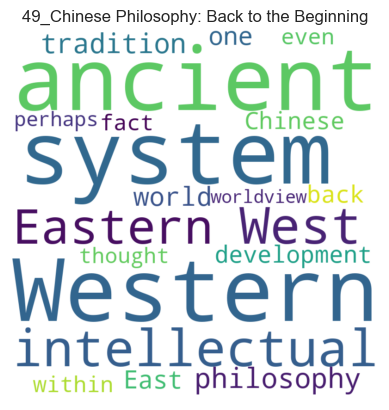

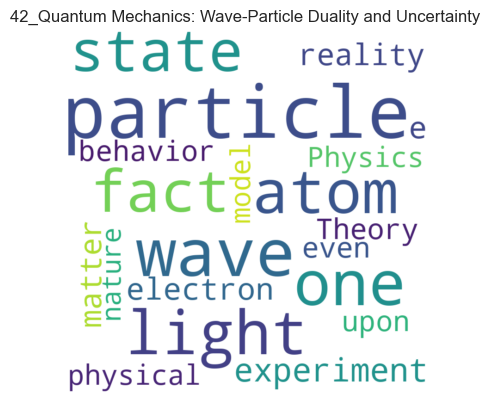

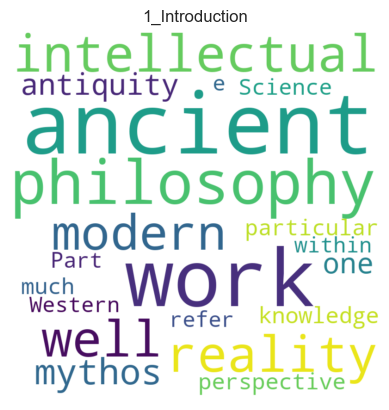

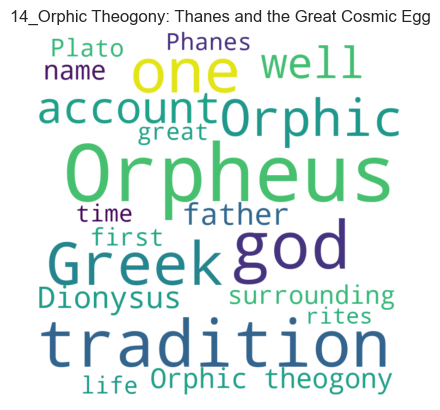

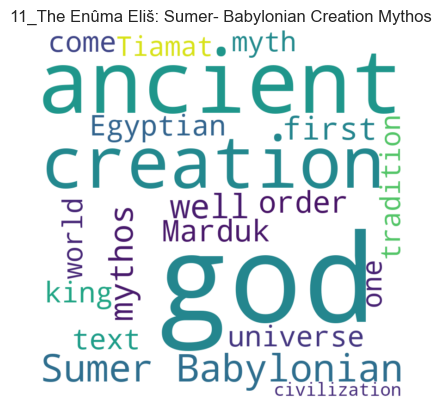

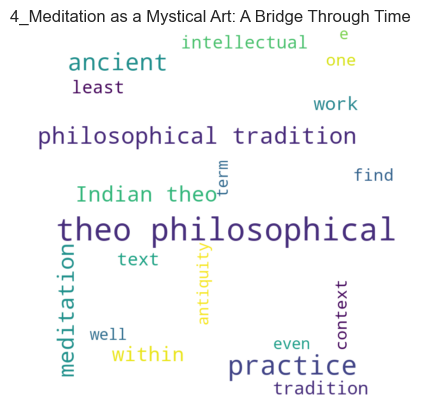

In [29]:
#
# WordCloud Visualizations per chapter
#

# Initialize a counter to keep track of the number of images displayed
count = 0

# Initialize an empty list to store the top 20 words in each file
top_words = []

directory = DIR

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if file is a text file
    if filename.endswith(".txt"):
        # Check if file size is greater than 0 bytes
        if os.path.getsize(os.path.join(directory, filename)) > 0:
            # Open the file and read its contents
            with open(os.path.join(directory, filename), "r", encoding='utf-8') as f:
                text = f.read()
            # Generate a WordCloud for the text
            wordcloud = WordCloud(width=800, height=800, background_color="white", max_words=20).generate(text)
            # Add the top 20 words to the list of top words
            top_words.append((os.path.splitext(filename)[0], wordcloud.words_))
            # Increment the counter
            count += 1
            # Display the WordCloud in a new column
            plt.figure()
            plt.title(os.path.splitext(filename)[0])
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
    # Stop processing files after displaying 20 images
    if count >= 20:
        break

# Display the top 20 words for each file
for filename, words in top_words:
    print(f"Top 20 words in {filename}: {list(words.keys())}")

# Show the plots
plt.show()

# Mathematical and Algebraic Preliminaries

## Term frequency-Inverse document-frequency (TF-IDF)

sources: 
- https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
- https://www.quora.com/How-does-TF-IDF-work

Here we switch from the bag of words text vectrorization technique to using the TF-IDF metric, which takes into account the 'uniqueness' of a given term relative to the corpus of documents (chapters in our case) in question.

*Term Frequency*
This measures the frequency of a word in a document. TF is individual to each document and word, hence we can formulate TF as follows:

**tf(t,d) = count of t in d / number of words in d**

*Document Frequency*
This measures the importance of documents in a whole set of the corpus. This is very similar to TF but the only difference is that TF is the frequency counter for a term t in document d, whereas DF is the count of occurrences of term t in the document set N. In other words, DF is the number of documents in which the word is present. We consider one occurrence if the term is present in the document at least once, we do not need to know the number of times the term is present.

**df(t) = occurrence of t in N documents**

To keep this also in a range, we normalize by dividing by the total number of documents. Our main goal is to know the informativeness of a term, and DF is the exact inverse of it. that is why we inverse the DF

*Inverse Document Frequency*
IDF is the inverse of the document frequency which measures the informativeness of term t. When we calculate IDF, it will be very low for the most occurring words such as stop words (because they are present in almost all of the documents, and N/df will give a very low value to that word). This finally gives what we want, a relative weightage.

**idf(t) = N/df**

Now there are few other problems with the IDF, when we have a large corpus size say N=10000, the IDF value explodes. So to dampen the effect we take the log of IDF.

As we cannot divide by 0, we smoothen the value by adding 1 to the denominator.

**idf(t) = log(N/(df + 1))**

*Formula*
Finally, by taking a multiplicative value of TF and IDF, we get the TF-IDF score. There are many different variations of TF-IDF but for now, let us concentrate on this basic version.

**tf-idf(t, d) = tf(t, d) * log(N/(df + 1))**

OR

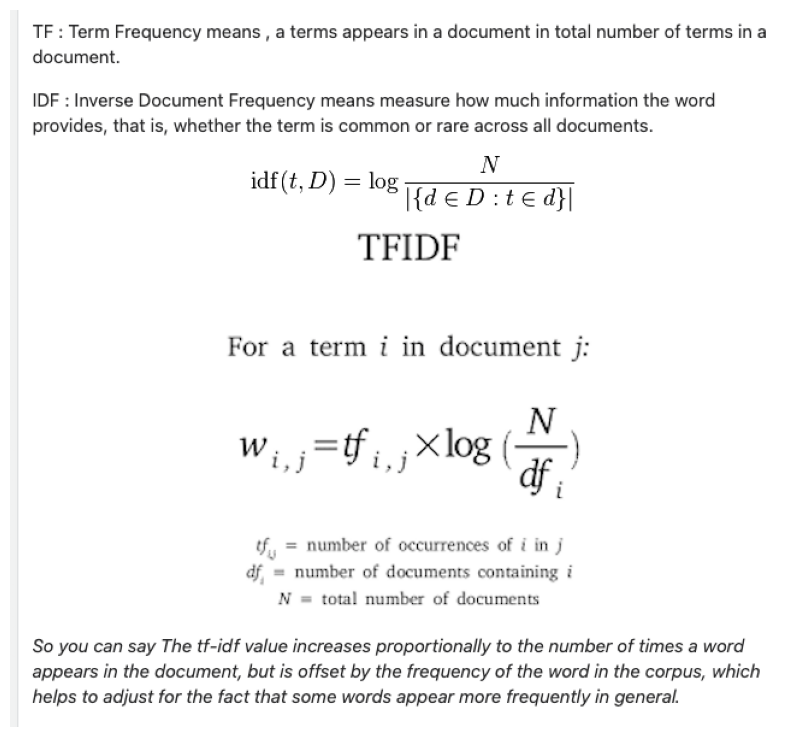

In [31]:
img = mpimg.imread(IMG_DIR + 'TF-IDF.png')

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)

## Singular Value Decomposition (Latent Semantic Analysis)

### Sources

- https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
- https://medium.com/sho-jp/linear-algebra-101-part-9-singular-value-decomposition-svd-a6c53ed2319e
- https://en.wikipedia.org/wiki/Singular_value_decomposition
- https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8#3ce3
- https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb

### Overview

Singular-Value Decomposition, or SVD for short, is a technique from linear algebra that allows for the factorization of a matrix into 'constituent' parts, parts that shed light on the nature of the matrix itself. It is a method that is used for both feature reduction (which is important in NLP given the sparse nature of the matrices used to represent text) as well as a technique that is used for (relevant here) Topic Modeling.

SVD is a matrix decomposition method, or (factorization method), for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler and again to break down the matrix into constituent parts (factorization). Unlike eigendecomposition wehich is a tool in linear algebra which is used where the matrix you want to decompose must be a square matrix, SVD allows you to decompose a rectangular matrix (a matrix that has different numbers of rows and columns). This is often more useful in a real-life scenario since the rectangular matrix could represent a wide variety of data that’s not a square matrix.

SVD is used widely both in the calculation of other matrix operations, such as matrix inverse, but also as a data reduction method in machine learning. SVD can also be used in least squares linear regression, image compression, and denoising data. It is also foundational to Latent Semantic Analysis (LSA), or Latent Semantic Indexing (LSI) as a feature reduction technique for NLP.

In [32]:
!pwd

/Users/peter/My Drive/FAU/Natural Language Processing (CAP6640)/Topic Modeling


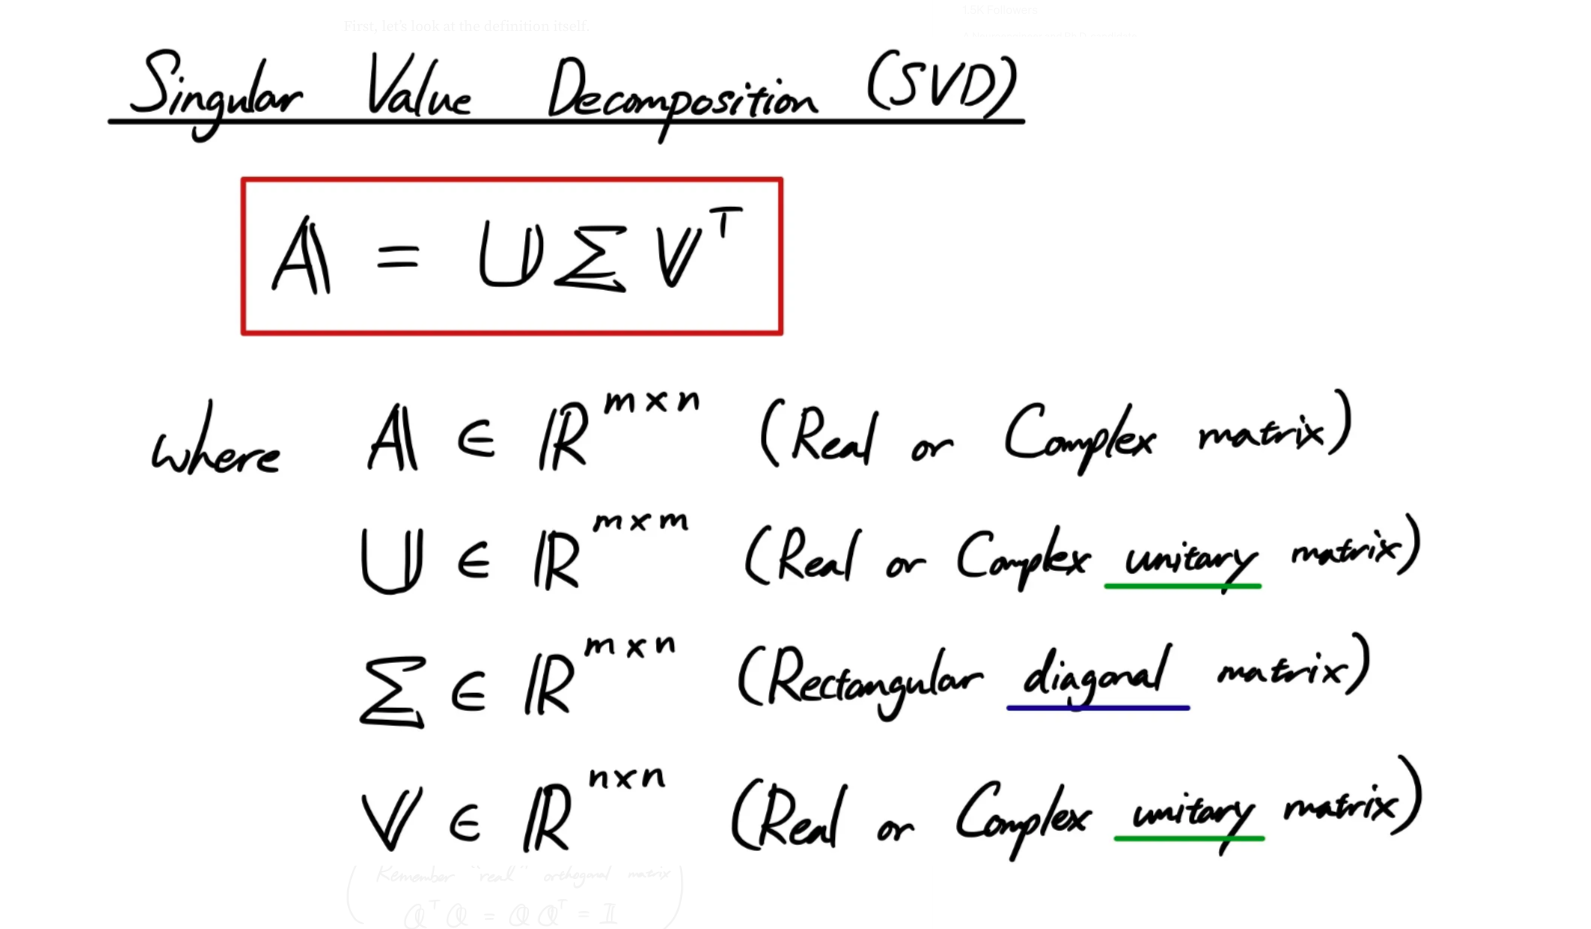

In [33]:
Image(filename=IMG_DIR + 'SVD Formula.png', width=600, height=600) 

Where 

- A is the real m x n matrix that we wish to decompose, 
- U is an m x m matrix, 
- Sigma (often represented by the uppercase Greek letter Sigma) is an m x n diagonal matrix, and 
- V^T is the  transpose of an n x n matrix where T is a superscript. 

The diagonal values in the Sigma matrix are known as the singular values of the original matrix A. The columns of the U matrix are called the left-singular vectors of A, and the columns of V are called the right-singular vectors of A.

Alternative explanation from Wikipedis:

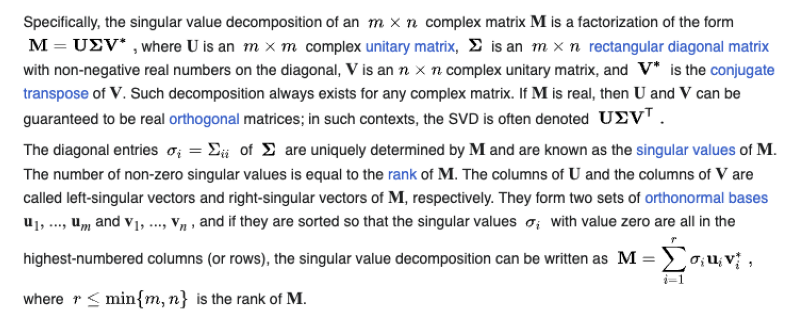

In [40]:
img = mpimg.imread(IMG_DIR + 'SVD wikipedia.png')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)

### The Math (linear algebra)

For the math, we going through two different interpretations of SVD: 

1) the general geometric decomposition that you can use with a real square matrix M, and 
2) the separable-models decomposition which is more pertinent to our example.

We will be **factorizing** this matrix into constituent matrices. When I say factorizing this is essentially the same as when we're taking a number and representing it its factors, which when multiplied together, give us the original number, e.g. A = B * C * D

This is also why it's called Singular Value **Decomposition** - we're decomposing it into its constituent parts.

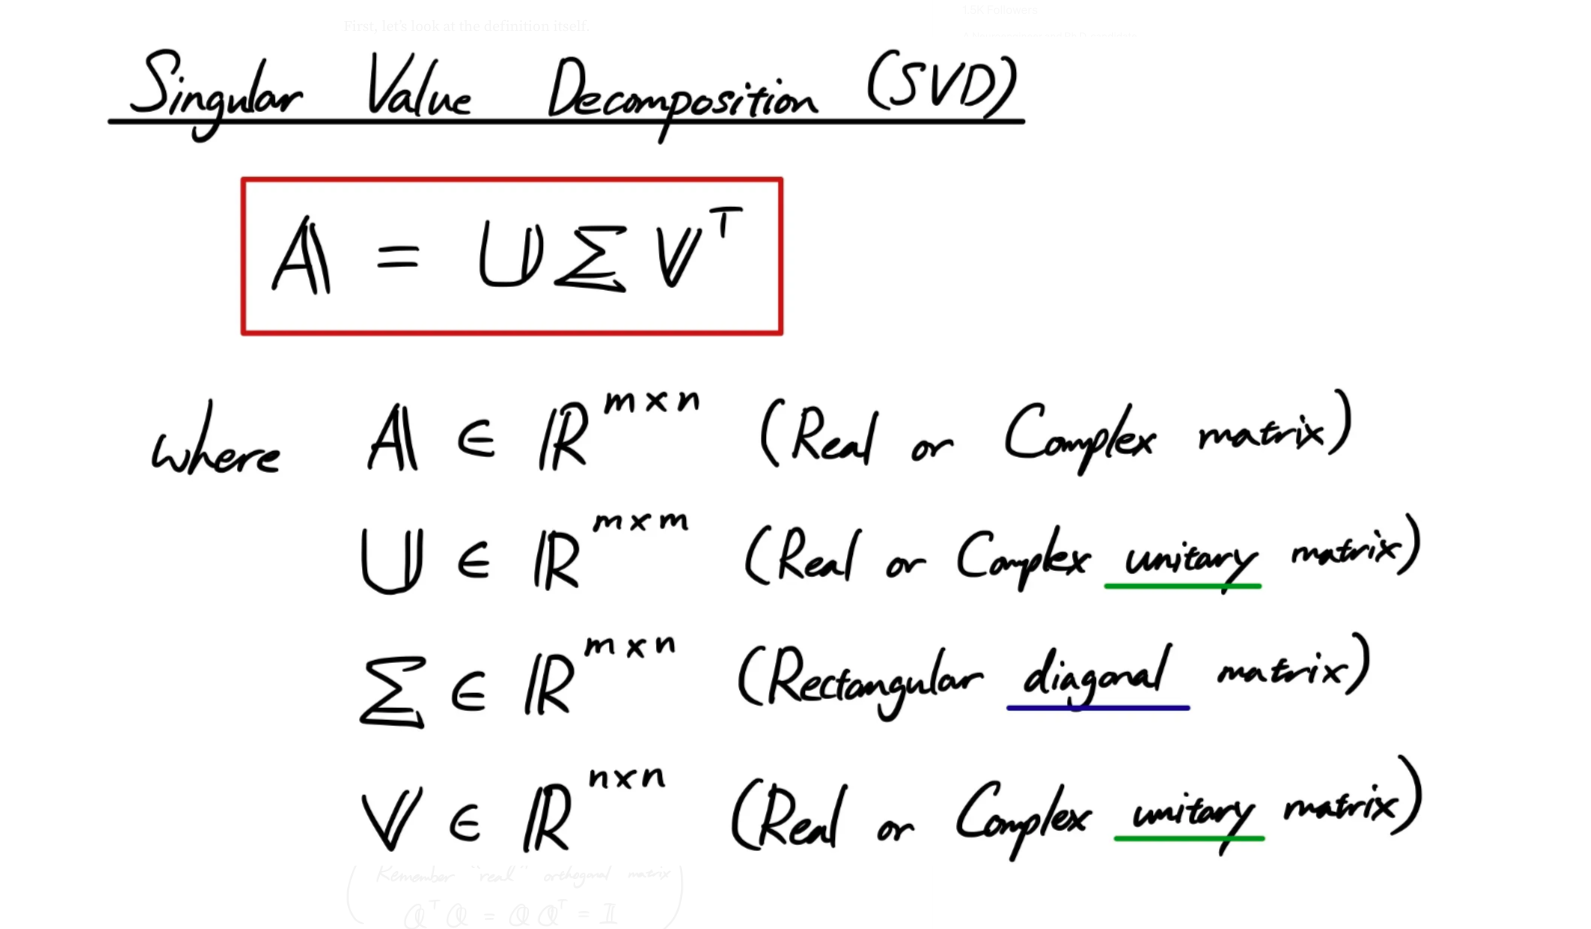

In [35]:
Image(filename=IMG_DIR + 'SVD Formula.png', width=600, height=600) 

**General geometric decomposition**

Now that extra dimension that wasn't available to us on the left-hand side, the r dimension, is the amount of latent concepts. Generally we're trying to represent our matrix as components that have one of their axes being this set of components. You will also note that, based on dimensions, the multiplication of the 3 matrices (when V is transposed) will lead us back to the shape of our original matrix, the r dimension effectively dissappearing. What matters in understanding the math is not the algebraic algorithm by which each number in U, V and Σ is determined, but the mathematical properties of these products and how they relate to each other.

First of all, it's important to consider first what a matrix actually is and what it can be thought of - a transformation on vector space. In the top left corner of Figure 7 we have two perpendicular vectors. If we have only two variables to start with then the feature space (the data that we're looking at) can be plotted anywhere in this space that is described by these two **basis** vectors. Now moving to the right in our diagram, the matrix M is applied to this vector space and this transforms it into the new, transformed space in our top right corner. In the diagram below the geometric effect of M would be referred to as "shearing" the vector space; the two vectors σ1 and σ2 are actually our singular values plotted in this space.

Now, just like with geometric transformations of points that you may remember from school, we can reconsider this transformation M as three separate transformations:

1. The rotation (or reflection) caused by V*. Note that V* = Vt as V is a real unitary matrix, so the complex conjugate of V is the same as its transpose. In vector terms, the transformation by V or V* keeps the length of the basis vectors the same;
2. Σ has the effect of stretching or compressing all coordinate points along the values of its singular values. Imagine our disc in the bottom left corner as we squeeze it vertically down in the direction of σ2 and stretch it horizontally along the direction of σ1. These two singular values now can be pictured as the major and minor semi-axes of an ellipse. You can of course generalize this to n-dimensions.
3. Lastly applying U rotates (or reflects) our feature space. We've arrived at the same output as a transformation directly from M.

I also recommend the excellent Wikipedia entry on SVD as it has a particularly good explanation and GIF of the process (https://en.wikipedia.org/wiki/Singular_value_decomposition).

Figure 7
Source: Wikipedia: Singular Value Decomposition; link: https://commons.wikimedia.org/wiki/File:Singular-Value-Decomposition.svg#filelinks; Author : Georg-Johann




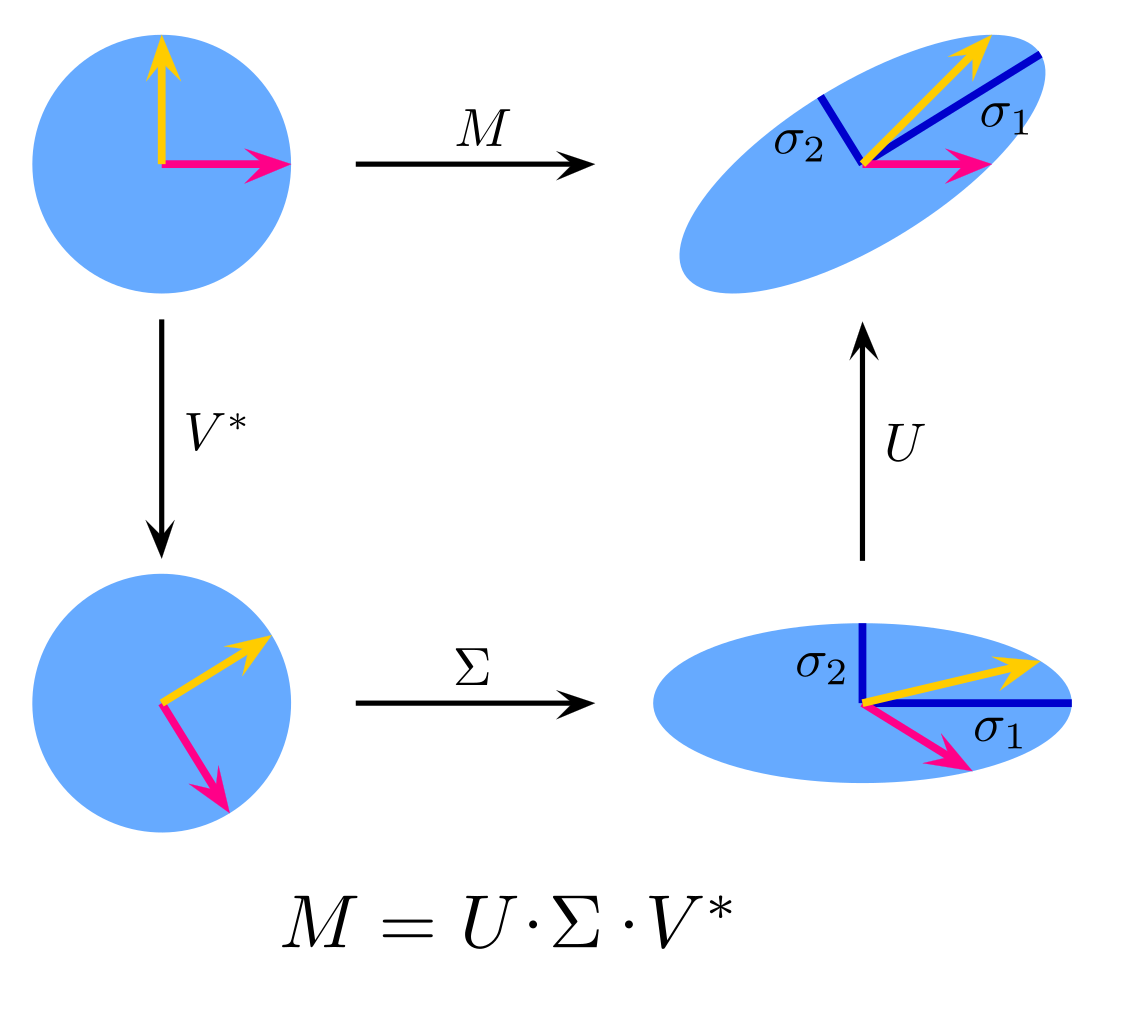

In [37]:
print('Figure 7')
print("Source: Wikipedia: Singular Value Decomposition; link: https://commons.wikimedia.org/wiki/File:Singular-Value-Decomposition.svg#filelinks; Author : Georg-Johann")
print("\n")
Image(filename=IMG_DIR + 'svd_wikipedia.png', width=600, height=600) 

So, in other words, where x is a column vector:


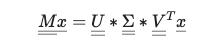

In [41]:
Image(filename=IMG_DIR + 'SVD_3.png')

One of the properties of the matrices U and V* is that they're unitary, we can say that the columns of both of these matrices form two sets of orthonormal basis vectors. I.e. the column vectors you can get from U would form their own coordinate space, such that if there were two columns: U1 and U2, you could write out all of the coordinates of the space as combinations of U1 and U2. The same applies to the columns of V, V1 and V2, and this would generalize to n-dimensions (you'd have n-columns).

### SVD Example (using Scikit Learn libraries)

In [42]:
#
# Singular-value decomposition code example and illustration
#
from numpy import array
from scipy.linalg import svd

# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print(A)

# SVD
U, s, VT = svd(A)

print(U)
print(s)
print(VT)

[[1 2]
 [3 4]
 [5 6]]
[[-0.2298477   0.88346102  0.40824829]
 [-0.52474482  0.24078249 -0.81649658]
 [-0.81964194 -0.40189603  0.40824829]]
[9.52551809 0.51430058]
[[-0.61962948 -0.78489445]
 [-0.78489445  0.61962948]]


A popular application of SVD is for dimensionality reduction. Data with a large number of features, such as more features (columns) than observations (rows) may be reduced to a smaller subset of features that are most relevant to the prediction problem. The result is a matrix with a lower rank that is said to approximate the original matrix. To do this we can perform an SVD operation on the original data and select the top k largest singular values in Sigma. These columns can be selected from Sigma and the rows selected from V^T. An approximate B of the original vector A can then be reconstructed.

**B = U . Sigmak . V^Tk**

In natural language processing, this approach can be used on matrices of word occurrences or word frequencies in documents and is called Latent Semantic Analysis or Latent Semantic Indexing. In practice, we can retain and work with a descriptive subset of the data called T. This is a dense summary of the matrix or a projection.

**T = U . Sigmak**

Further, this transform can be calculated and applied to the original matrix A as well as other similar matrices.

**T = V^k . A**

The example below demonstrates data reduction with the SVD. First a 3×10 matrix is defined, with more columns than rows. The SVD is calculated and only the first two features are selected. The elements are recombined to give an accurate reproduction of the original matrix. Finally the transform is calculated two different ways.

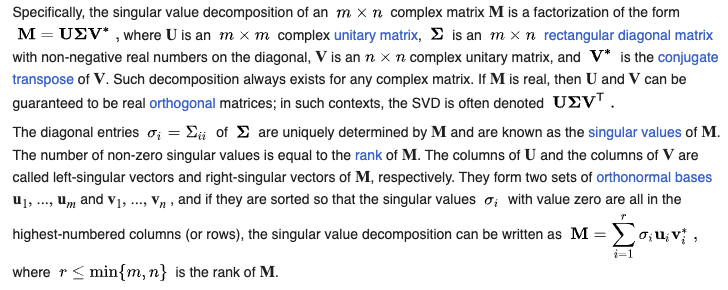

In [43]:
Image(filename=IMG_DIR + 'SVD wikipedia.png') 

In [44]:
from numpy import array
from numpy import diag
from numpy import zeros
from scipy.linalg import svd

# define a matrix
M = array([
 [1,2,3,4,5,6,7,8,9,10],
 [11,12,13,14,15,16,17,18,19,20],
 [21,22,23,24,25,26,27,28,29,30]])

print("M:")
print(M.shape)
print(M)
print()

M:
(3, 10)
[[ 1  2  3  4  5  6  7  8  9 10]
 [11 12 13 14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27 28 29 30]]



In [45]:
# Singular-value decomposition
U, s, VT = svd(M)

print("U:")
print(U.shape)
print(U)
print("Sigma:")
print(s.shape)
print(s)
print("VT:")
print(VT.shape)
print(VT)

U:
(3, 3)
[[-0.19101157  0.89266338  0.40824829]
 [-0.51371859  0.26348917 -0.81649658]
 [-0.8364256  -0.36568503  0.40824829]]
Sigma:
(3,)
[9.69657342e+01 7.25578339e+00 5.43064394e-15]
VT:
(10, 10)
[[-0.24139304 -0.25728686 -0.27318068 -0.2890745  -0.30496832 -0.32086214
  -0.33675595 -0.35264977 -0.36854359 -0.38443741]
 [-0.53589546 -0.42695236 -0.31800926 -0.20906617 -0.10012307  0.00882003
   0.11776313  0.22670623  0.33564933  0.44459242]
 [-0.71590327  0.22125777  0.35844894  0.23137425  0.12099174  0.27768425
  -0.35015608  0.05691924 -0.00338669 -0.19723014]
 [-0.03274747 -0.17891449 -0.37608172  0.89207072 -0.08211107 -0.11995167
   0.02920549 -0.06831525 -0.05443306 -0.00872147]
 [-0.07588946 -0.05763181 -0.30552732 -0.08865234  0.92223855 -0.12098055
  -0.00525156 -0.09919877 -0.09845351 -0.07065325]
 [ 0.06629874  0.08438747 -0.47449715 -0.0967393  -0.08248279  0.8362855
   0.03555043 -0.13520148 -0.138849   -0.09475243]
 [-0.33592049  0.16549299  0.06013546 -0.02444478 -

In [46]:
# create m x n Sigma matrix
Sigma = zeros((M.shape[0], M.shape[1]))

# populate Sigma with n x n diagonal matrix
Sigma[:M.shape[0], :M.shape[0]] = diag(s)

# select
n_elements = 2
Sigma = Sigma[:, :n_elements]
VT = VT[:n_elements, :]

# reconstruct
B = U.dot(Sigma.dot(VT))
print("B")
print(B.shape)
print(B)

# transform
T = U.dot(Sigma)
print("T")
print(T.shape)
print(T)
T = M.dot(VT.T)
print("T")
print(T.shape)
print(T)


B
(3, 10)
[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]]
T
(3, 2)
[[-18.52157747   6.47697214]
 [-49.81310011   1.91182038]
 [-81.10462276  -2.65333138]]
T
(3, 2)
[[-18.52157747   6.47697214]
 [-49.81310011   1.91182038]
 [-81.10462276  -2.65333138]]


The scikit-learn provides a TruncatedSVD class that implements this capability directly. The TruncatedSVD class can be created in which you must specify the number of desirable features or components to select, e.g. 2. Once created, you can fit the transform (e.g. calculate V^Tk) by calling the fit() function, then apply it to the original matrix by calling the transform() function. The result is the transform of A called T above.

In [47]:
from numpy import array
from sklearn.decomposition import TruncatedSVD

M = array([
 [1,2,3,4,5,6,7,8,9,10],
 [11,12,13,14,15,16,17,18,19,20],
 [21,22,23,24,25,26,27,28,29,30]])

print("M")
print(M.shape)
print(M)

M
(3, 10)
[[ 1  2  3  4  5  6  7  8  9 10]
 [11 12 13 14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27 28 29 30]]


In [48]:
# svd
svd = TruncatedSVD(n_components=2)
svd.fit(M)
result = svd.transform(M)
print(result)

[[18.52157747  6.47697214]
 [49.81310011  1.91182038]
 [81.10462276 -2.65333138]]


Running the example first prints the defined matrix, followed by the transformed version of the matrix. We can see that the values match those calculated manually above, except for the sign on some values. We can expect there to be some instability when it comes to the sign given the nature of the calculations involved and the differences in the underlying libraries and methods used. This instability of sign should not be a problem in practice as long as the transform is trained for reuse.

## Dirichlet Distribution (Latent Dirichlet Allocation)

### Sources

Beta desitribution: https://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution/47782#47782

Dirichlet distribution:
- https://stats.stackexchange.com/questions/244917/what-exactly-is-the-alpha-in-the-dirichlet-distribution
- https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution
- https://en.wikipedia.org/wiki/Dirichlet_distribution

### Algorithm Overview

Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

**Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}

**Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight

**Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this article, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

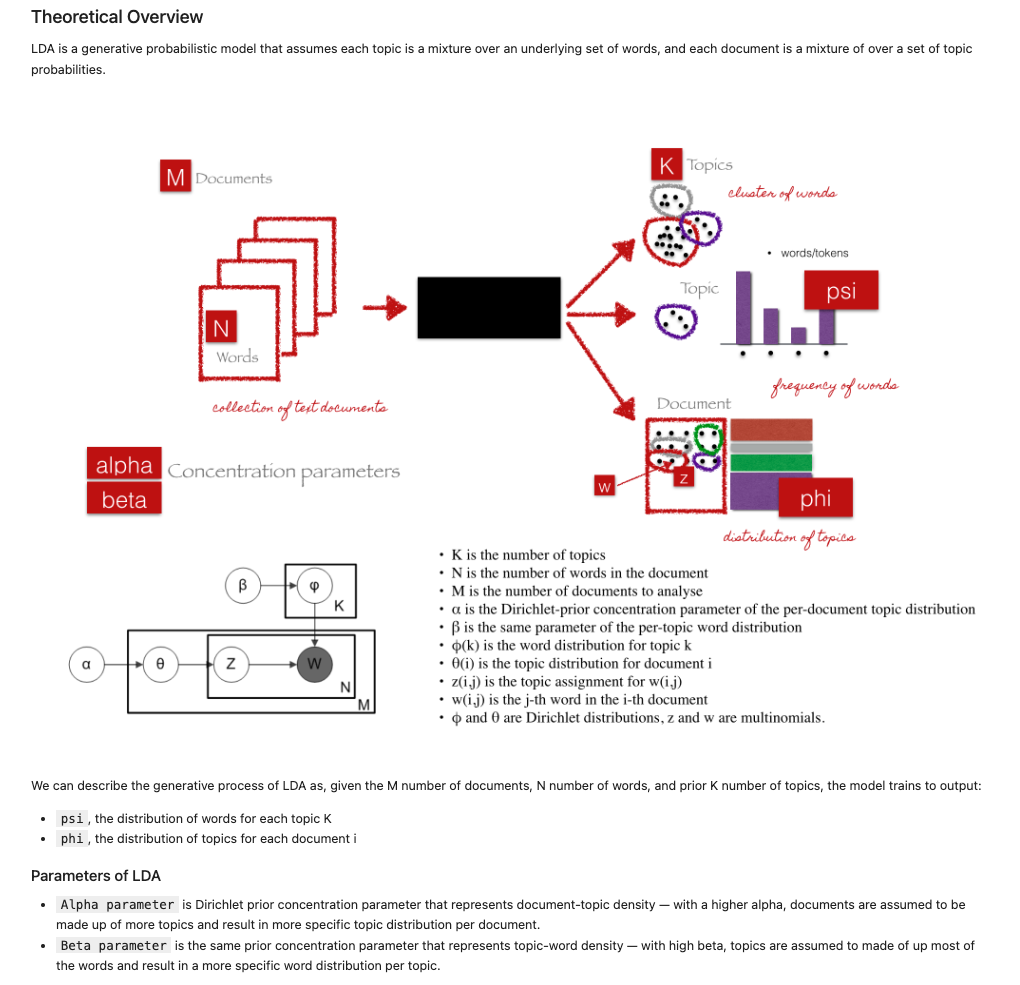

In [49]:
Image(filename=IMG_DIR + 'LDA Theoretical Overview Kapadia.png') 

### Mathematics (Probability Distributions)

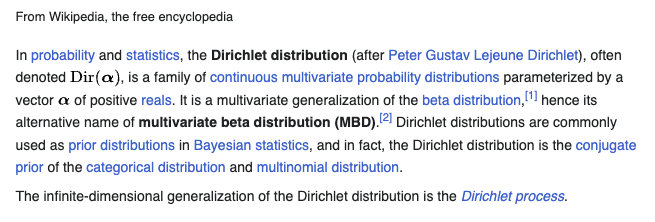

In [50]:
Image(filename=IMG_DIR + 'Dirichlet distribution wikipedia.png') 

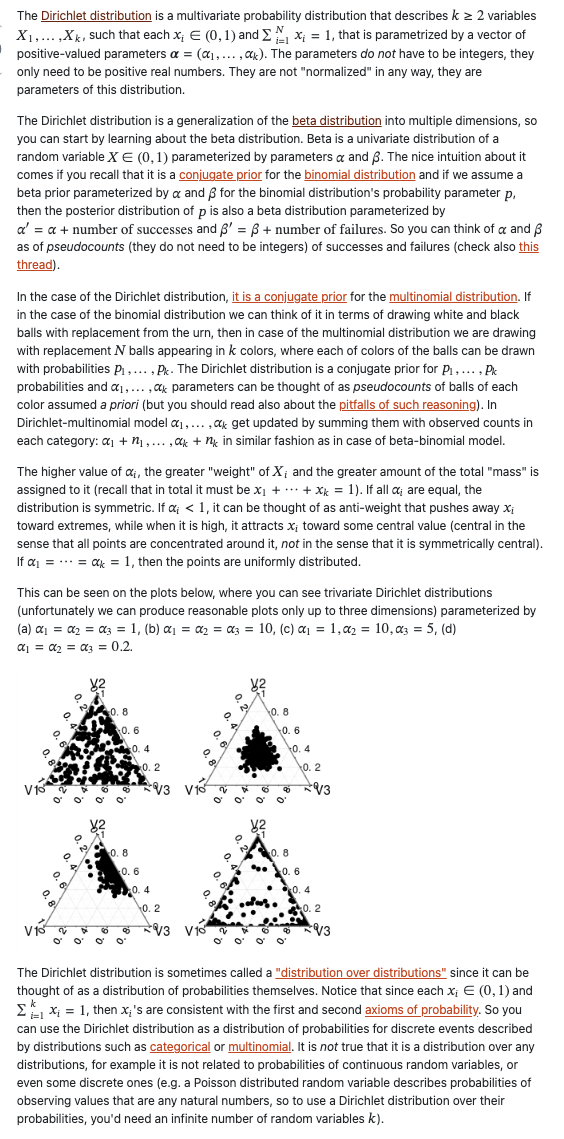

In [51]:
Image(filename=IMG_DIR + 'Dirichlet distribution 2.png') 

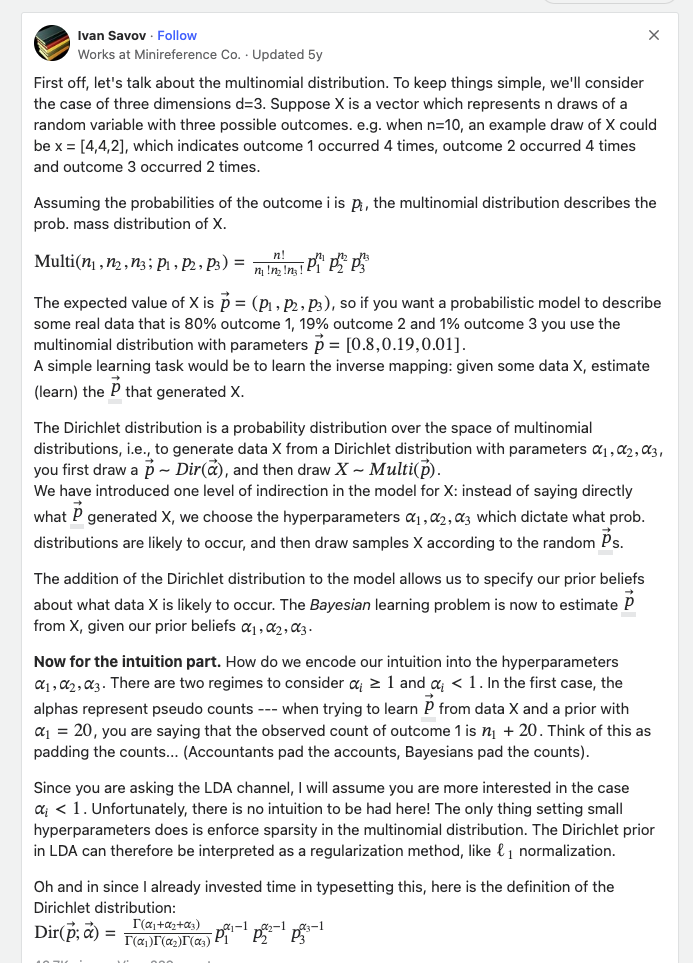

In [52]:
Image(filename=IMG_DIR + 'Dirichlet distribution.png') 

## Non-negative matrix factorization (NMF)

### Sources

- https://en.wikipedia.org/wiki/Non-negative_matrix_factorization
- https://www.centerspace.net/clustering-analysis-part-iv-non-negative-matrix-factorization

### The Math

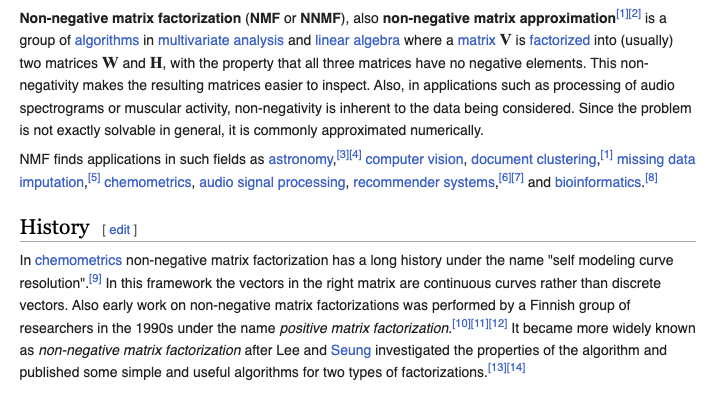

In [53]:
Image(filename=IMG_DIR + 'NMF 1.png') 

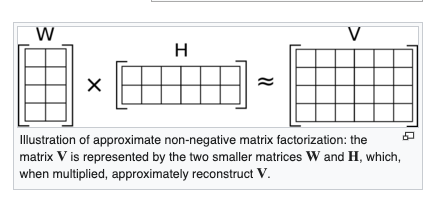

In [54]:
Image(filename=IMG_DIR + 'NMF 2.png', width=800, height=400) 

If V in an ***n*** x ***m*** matrix, then NMF can be used to approximately factor ***V*** into an ***n*** x ***r*** matrix ***W*** and an ***r*** x ***m*** matrix ***H***. 

Usually ***r*** is chosen to be much smaller than either ***m*** or ***n***, for dimension reduction. Thus, each column of ***V*** is approximated by a linear combination of the columns of ***W***, with the coefficients being the corresponding column ***H***. This extracts underlying features of the data as basis vectors in ***W***, which can then be used for identification, clustering, and compression.

## K-Means Clustering



### Sources 

- https://en.wikipedia.org/wiki/K-means_clustering
- https://towardsdatascience.com/how-to-easily-cluster-textual-data-in-python-ab27040b07d8

### The Algorithm

K-Means is one of the most popular "clustering" algorithms. K-means stores $k$ centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid.

K-Means finds the best centroids by alternating between 

(1) assigning data points to clusters based on the current centroids 
(2) chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.

till convergence..

![](https://i.imgur.com/42n9uvR.png)

Features we are using here are BOW based features

The K-means algorithm primary aim is to minimise the within-cluster sum of squares (or inertia) by creating clusters of similar variance. First, the number of clusters must be specified and then this same number of ‘centroids’ are randomly allocated. The Euclidean distance is then measured between each data point and the centroids. The data point is then ‘assigned’ to the centroid which is closest. We then take the mean of the newly generated clusters as our new centroids and repeat the previous steps. This process then repeats until convergence or the max number of iterations is reached. 

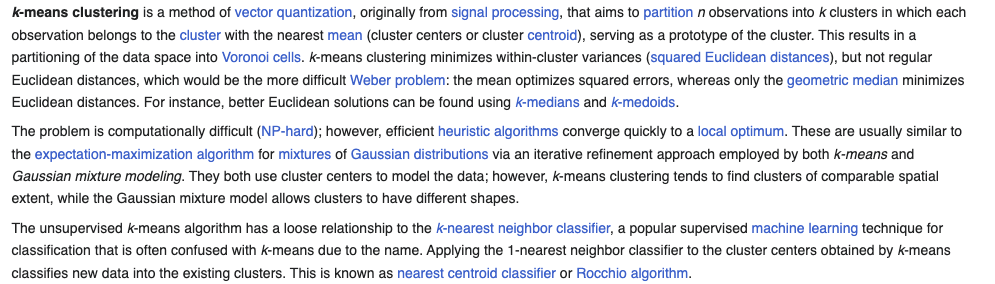

In [55]:
Image(filename=IMG_DIR + 'kmeans fig3.png') 

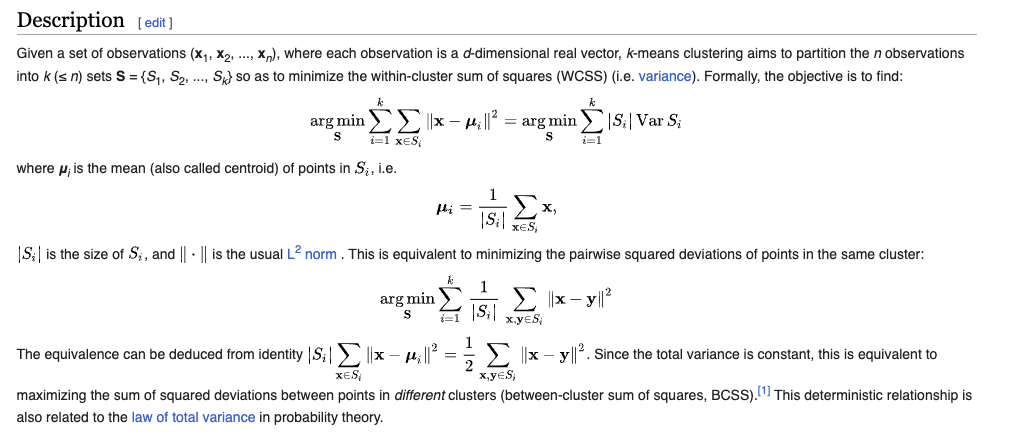

In [56]:
Image(filename=IMG_DIR + 'kmeans fig4.png') 

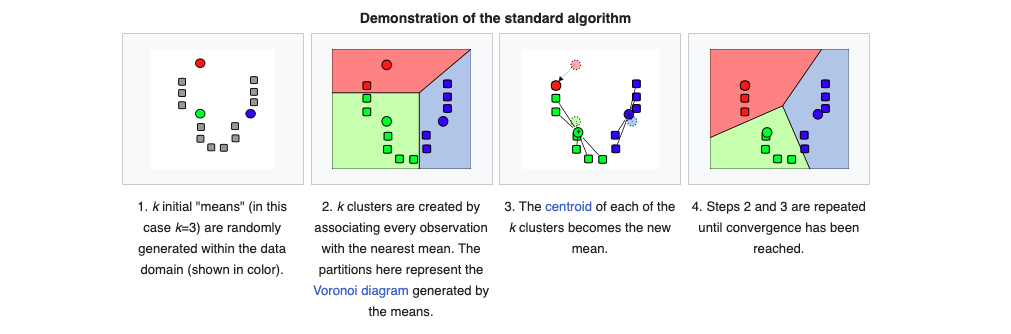

In [57]:
Image(filename=IMG_DIR + 'kmeans fig5.png') 

## Hierarchical Clustering

### Sources

- https://towardsdatascience.com/a-friendly-introduction-to-text-clustering-fa996bcefd04

- https://en.wikipedia.org/wiki/Hierarchical_clustering

### The Algorithm

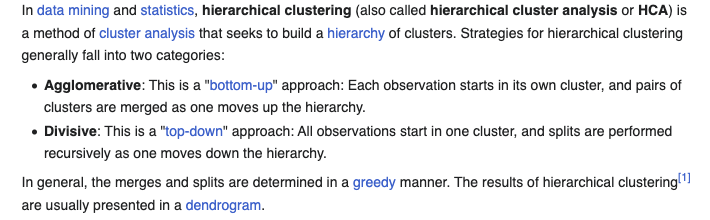

In [58]:
Image(filename=IMG_DIR + 'hierarchical 2.png') 

Hierarchical methods can be further divided into two subcategories. Agglomerative (“bottom up”) methods start by putting each object into its own cluster and then keep unifying them. Divisive (“top down”) methods do the opposite: they start from the root and keep dividing it until only single objects are left.

In order to decide which clusters should be combined (for agglomerative), or where a cluster should be split (for divisive), a measure of dissimilarity between sets of observations is required. In most methods of hierarchical clustering, this is achieved by use of an appropriate distance *d*, such as the Euclidean distance, between single observations of the data set, and a linkage criterion, which specifies the dissimilarity of sets as a function of the pairwise distances of observations in the sets. The choice of metric as well as linkage can have a major impact on the result of the clustering, where the lower level metric determines which objects are most similar, whereas the linkage criterion influences the shape of the clusters. For example, complete-linkage tends to produce more spherical clusters than single-linkage.

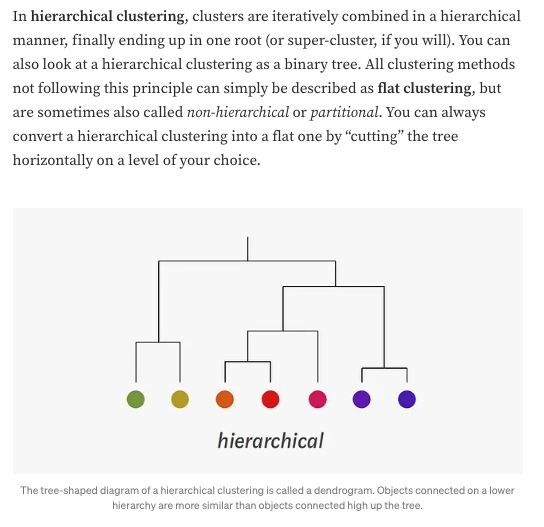

In [59]:
Image(filename=IMG_DIR + 'hierarchical 1.png') 

# Clustering Examples

## Example 1: K-Means with CountVectorizer (BoW)

source: ??? 


In [60]:
# install once
!pip install contractions

  Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.9 MB/s eta 0:00:00a 0:00:01


In [61]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/peter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
import contractions

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [63]:
normalize_corpus = np.vectorize(normalize_document)

norm_tr_corpus = normalize_corpus(list(chapters.values()))

In [64]:
norm_tr_corpus[0]

"ever since dawn civilization mankind created mythological semantic metaphysical paradigms within nature existence knowledge along underlying order heavens earth creatures within mankind included could explained modern times evolution thought call culminated predominantly deterministic empiricist view reality one completely absent symbols psychological import act perception upon view reality development looked unintended potentially destructive byproduct socalled developments intellectual progress marked characteristic scientific revolution enlightenment era history western civilization altogether western theophilosophical developments evolved modern science emerged cultural melting pot mediterranean began first persian greek empires first millennium bce followed development subsequent spread monotheism first latinroman imperial conquests counteracted fueled even spread islam forces ultimately culminated revolutionary developments characteristic enlightenment era period history religio

In [65]:
#stop_words = stop_words + ['one', 'two', 'three', 'four', 'five', 'get']

cv = CountVectorizer(
    ngram_range=(1, 2), 
    #min_df=0.001, 
    #max_df=0.99, 
    stop_words=stop_words)

cv_matrix = cv.fit_transform(norm_tr_corpus)

cv_matrix.shape

(52, 139261)

In [66]:
km_bow = KMeans(
    n_clusters=NUM_TOPICS, 
    max_iter=10000, 
    n_init=100, 
    verbose=0,
    random_state=42
    )

km_bow.fit(cv_matrix)

KMeans(max_iter=10000, n_clusters=6, n_init=100, random_state=42)

In [67]:
write_cluster_info(
    filename='tm_kmeans_bow', 
    vector=cv,
    km=km_bow)

--------------------------------- CLUSTER #0 ---------------------------------
Key Features: ['ancient', 'philosophical', 'one', 'tradition', 'also', 'well', 'first', 'chinese', 'philosophy', 'bce', 'world', 'antiquity']
Chapters:
2: 50_Vedic Theology: Vedānta and Brahmavidyā
3: 3_A Brief History of the Mystical Arts: Beyond Yoga
4: 23_Upanishadic Philosophy: Brahmavidyā and the Soul
5: 33_The Indo-Europeans: The Grandparents of Philosophy
6: 8_From Language to Writing: The Dawn of History
7: 30_Indo-European Theo-Philosophy: On the Soul
8: 47_Modern Psychology: Freud Versus Jung
10: 16_Ancient Chinese Theology: Shàngdì, Pángǔ, Tiān and the Dao
12: 26_The Legacy of Socrates: Skepticism, Knowledge and Reason
13: 31_Logos from Mythos: The Heart of Eurasian Philosophy
14: 49_Chinese Philosophy: Back to the Beginning
17: 14_Orphic Theogony: Thanes and the Great Cosmic Egg
18: 11_The Enûma Eliš: Sumer- Babylonian Creation Mythos
19: 4_Meditation as a Mystical Art: A Bridge Through Time 
22:

## Example 2: K-Means with TfidfVectorizer

source: http://brandonrose.org/clustering

In [68]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=200000,
    use_idf=True,
    ngram_range=(1, 2), 
    min_df=0.001, 
    max_df=0.99, 
    stop_words=stop_words)

#%time tfidf_matrix = tfidf_vectorizer.fit_transform(chaps)

tfidf_matrix = tfidf_vectorizer.fit_transform(norm_tr_corpus)

In [69]:
tfidf_matrix.shape

(52, 139246)

In [70]:
#terms = tfidf_vectorizer.get_feature_names_out()

dist = 1 - cosine_similarity(tfidf_matrix)          # for hierarchical clustering (below)

km_tfidf = KMeans(
    n_clusters=NUM_TOPICS, 
    max_iter=10000, 
    n_init=100, 
    verbose=0,
    random_state=42)

km_tfidf.fit(tfidf_matrix)

KMeans(max_iter=10000, n_clusters=6, n_init=100, random_state=42)

In [71]:
write_cluster_info(
    filename='tm_kmeans_tfidf', 
    vector=tfidf_vectorizer,
    km=km_tfidf)

--------------------------------- CLUSTER #0 ---------------------------------
Key Features: ['plato', 'philosophy', 'aristotle', 'knowledge', 'stoic', 'socrates', 'tradition', 'upon', 'hellenic', 'suffering', 'reason', 'existence']
Chapters:
0: 39_The Age of Enlightenment: The Philosophy of Science
8: 47_Modern Psychology: Freud Versus Jung
12: 26_The Legacy of Socrates: Skepticism, Knowledge and Reason
22: 34_Hellenic Theo-Philosophy: From Mythos to Logos
24: 35_Aristotle's Metaphysics: Causality and Theology in Antiquity
28: 36_Stoicism: Naturalism, Corporealism and Logos
32: 37_The Seeds of Christianity: The Hellenization of Judaism
40: 38_Islamic Philosophy: Allāh as the Final Cause
43: 25_Pythagoras: The Father of Hellenic Philosophy
45: 40_The Metaphysics of Morality: Kantian Cognitive Ontology
47: 27_Plato and the Allegory of the Cave: Ideas, Being and Becoming
51: 24_Buddhist Philosophy: Impermanence, Suffering and the "No-Self"
------------------------------------------------

## Example 3: Hierarchical Clustering (dendrogram)

source: http://brandonrose.org/clustering

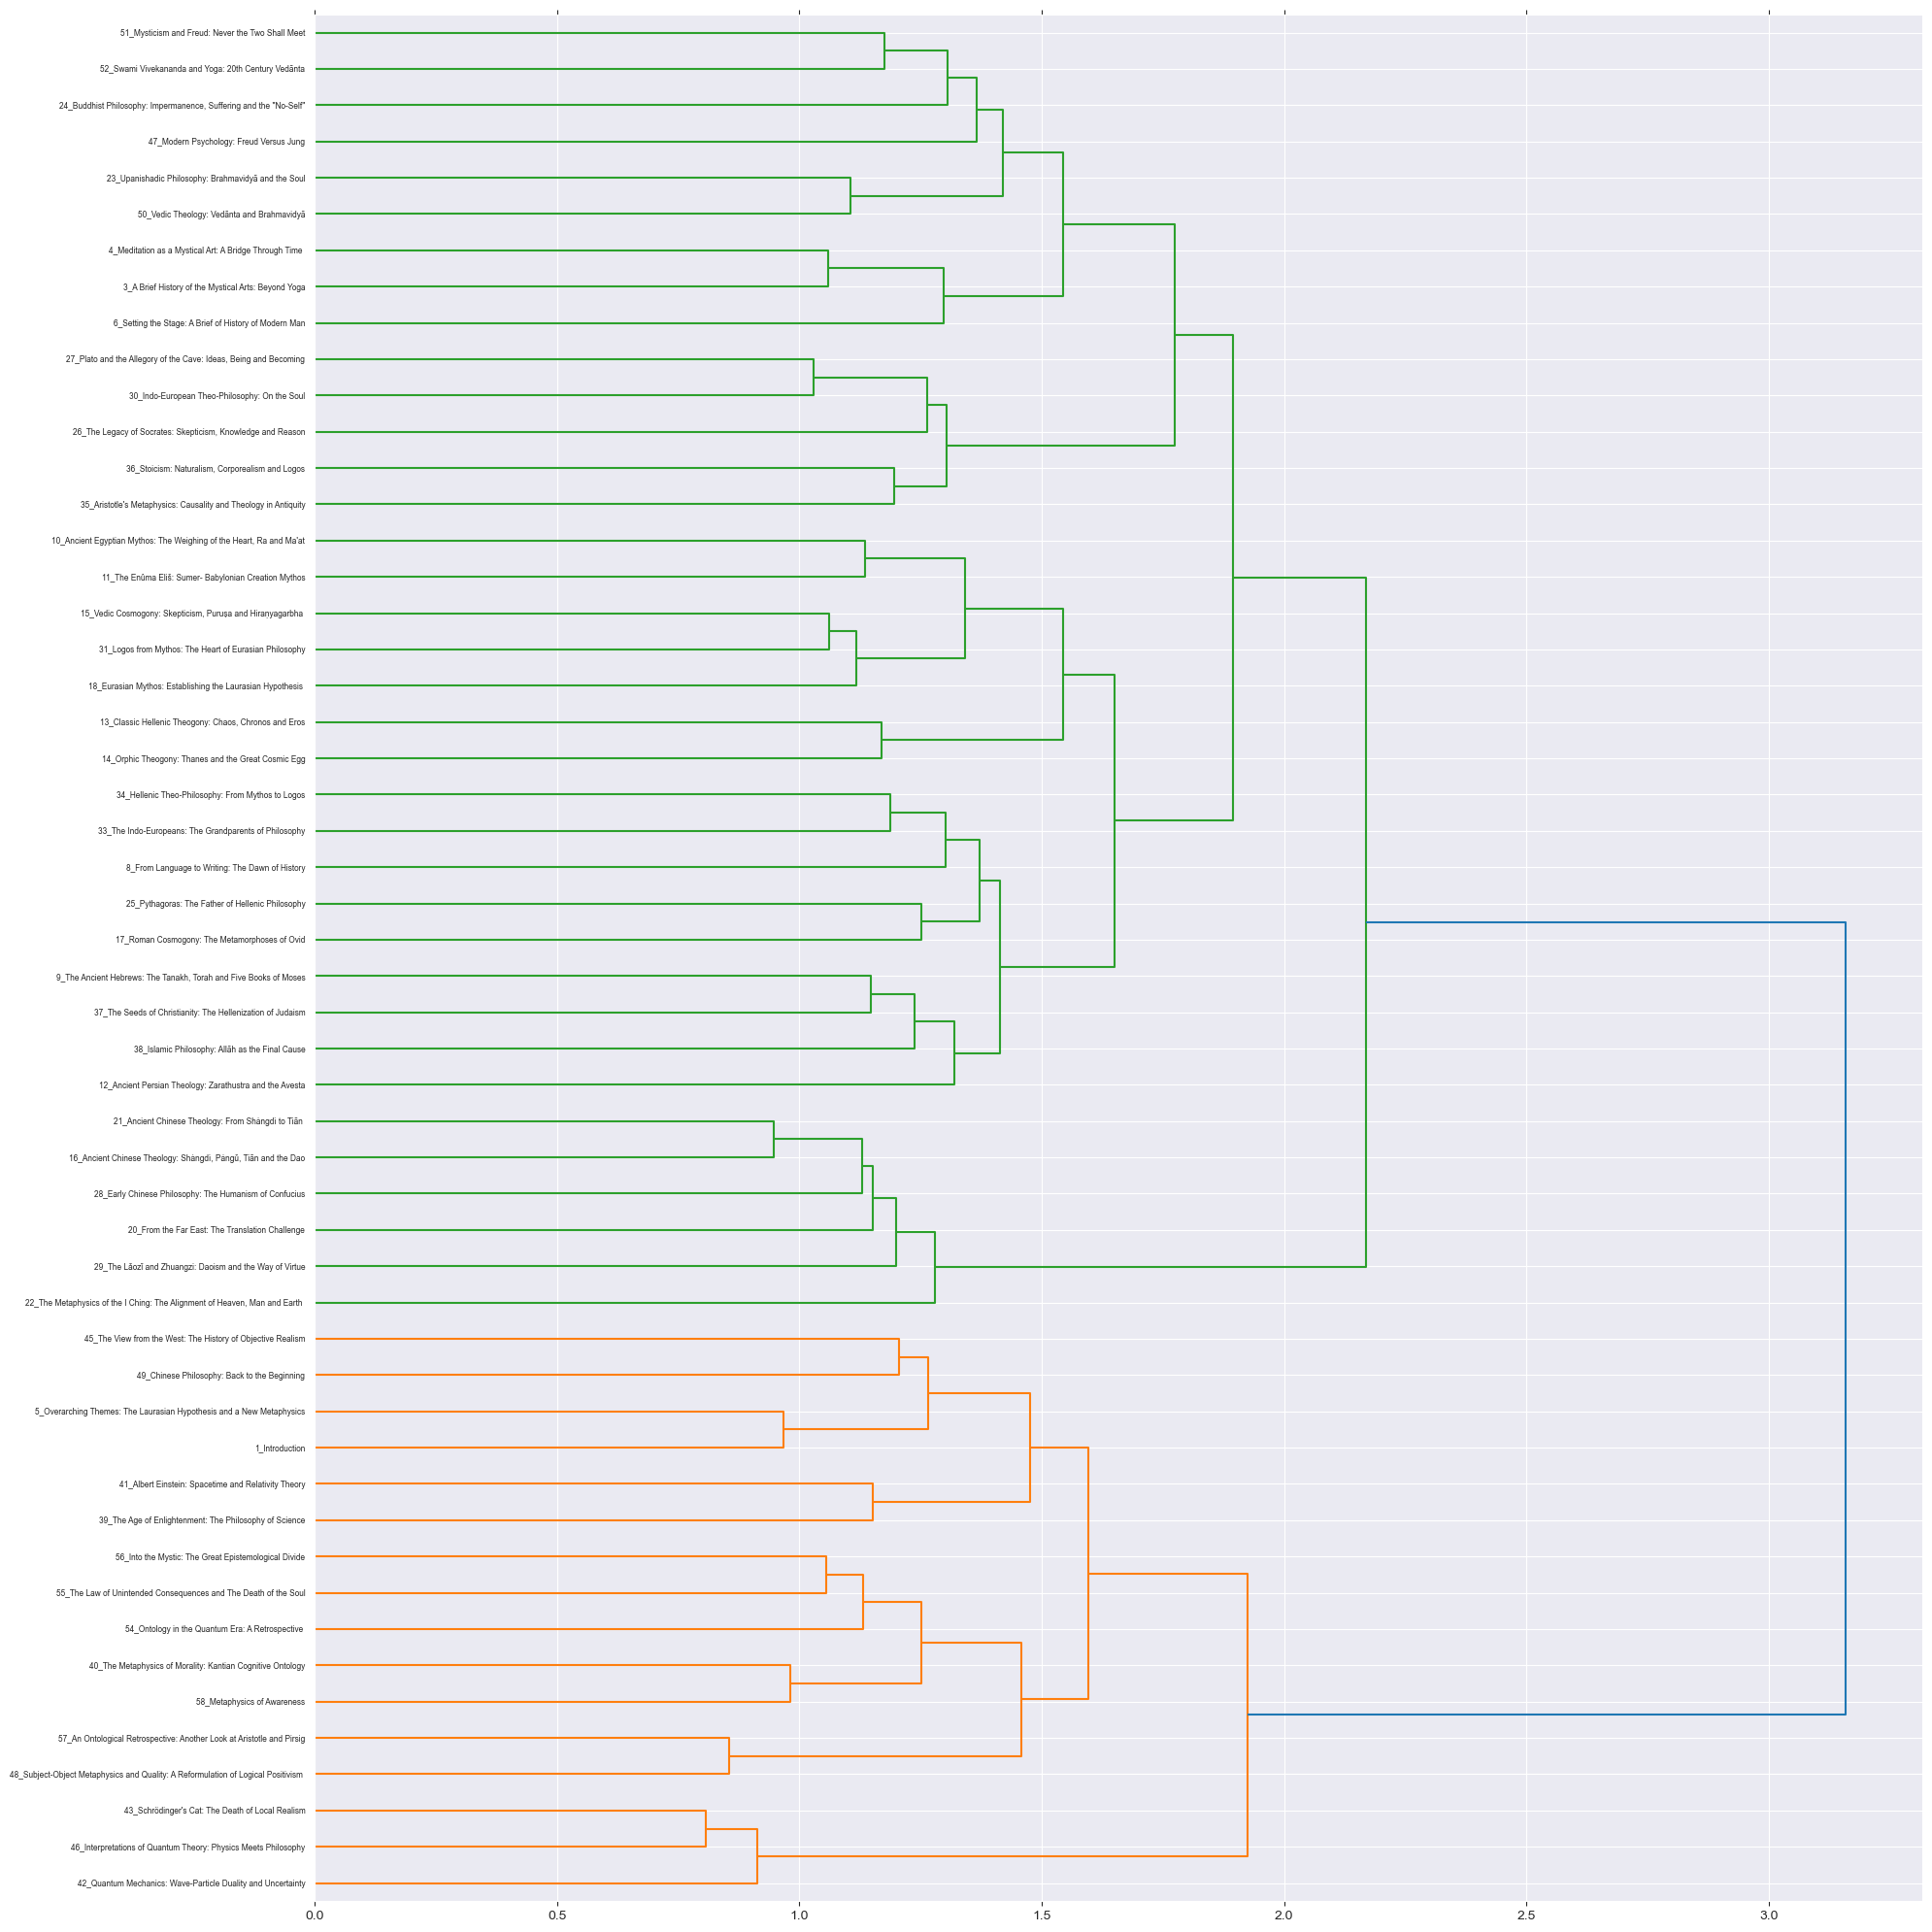

In [72]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 20)) # set size

ax = dendrogram(linkage_matrix, orientation="right", labels=chap_titles);

plt.tick_params(\
    axis= 'x',            # changes apply to the x-axis
    which='both',         # both major and minor ticks are affected
    bottom='off',         # ticks along the bottom edge are off
    top='off',            # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()        #show plot with tight layout

plt.savefig(OUT_DIR + 'tr_hier_clusters.png', dpi=200)      #save figure as ward_clusters

In [73]:
plt.close()

## Example 4: Non-negative Matrix Factorization (NMF) with TfidfVectorizer

sources: 
- https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8
- https://predictivehacks.com/topic-modelling-with-nmf-in-python/

In [74]:
nmf_model = NMF(NUM_TOPICS)

doc_topic = nmf_model.fit_transform(tfidf_matrix)

In [75]:
np.set_printoptions(precision=4)

index = 0
for title in chap_titles:
  print(doc_topic[index], title, np.argmax(doc_topic[index]))
  index += 1

[0.     0.1012 0.     0.1596 0.2045 0.011 ] 39_The Age of Enlightenment: The Philosophy of Science 4
[0.     0.6652 0.     0.     0.     0.    ] 46_Interpretations of Quantum Theory: Physics Meets Philosophy 1
[0.012  0.     0.     0.     0.     0.6239] 50_Vedic Theology: Vedānta and Brahmavidyā 5
[0.4485 0.     0.     0.     0.     0.    ] 3_A Brief History of the Mystical Arts: Beyond Yoga 0
[0.     0.     0.     0.     0.     0.5835] 23_Upanishadic Philosophy: Brahmavidyā and the Soul 5
[0.2177 0.     0.     0.1422 0.0134 0.0156] 33_The Indo-Europeans: The Grandparents of Philosophy 0
[0.1758 0.     0.0105 0.161  0.     0.    ] 8_From Language to Writing: The Dawn of History 0
[0.     0.0045 0.006  0.0288 0.0629 0.4614] 30_Indo-European Theo-Philosophy: On the Soul 5
[0.     0.0439 0.0094 0.0092 0.1544 0.1022] 47_Modern Psychology: Freud Versus Jung 4
[0.0172 0.0046 0.     0.     0.     0.5071] 52_Swami Vivekananda and Yoga: 20th Century Vedānta 5
[0.     0.     0.4914 0.0582 0.    

In [76]:
topic_names = None

dt_str = datetime.now().strftime("%m%d%Y")
file = open(OUT_DIR + 'tm_nmf' + '_' + dt_str + '.txt', 'w+', encoding='utf-8')
feature_names = tfidf_vectorizer.get_feature_names_out()

#
# iterate through topics in topic-term matrix, 'H' aka model.components_
#
for cluster, topic in enumerate(nmf_model.components_):
  
  out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
  print(out_str)
  file.write(out_str + '\n')

  key_features = ", ".join([feature_names[i] \
      for i in topic.argsort()[:-NUM_WORDS - 1:-1]])
  
  print('Key Features (terms): ' + key_features)
    
  file.write("Key Features (terms): ")
  for feat in key_features:
    file.write(feat)
  file.write('\n')

  out_str = 'Chapters:'
  print(out_str)
  file.write(out_str + '\n')

  chap_ind = 0
  for title in chap_titles:
    if (np.argmax(doc_topic[chap_ind]) == cluster):
      #print(doc_topic[chap_ind].round(decimals=2), title)
      out_str = title 
      print(out_str)
      file.write(out_str + '\n')
    
    chap_ind += 1

  out_str = '-'*140 
  print(out_str, '\n')
  file.write(out_str + '\n\n')

file.close()

--------------------------------- CLUSTER #0 ---------------------------------
Key Features (terms): ancient, eurasia, theo, theo philosophical, writing, work, intellectual, ramakrishna, meditation, tradition, antiquity, throughout
Chapters:
3_A Brief History of the Mystical Arts: Beyond Yoga
33_The Indo-Europeans: The Grandparents of Philosophy
8_From Language to Writing: The Dawn of History
1_Introduction
4_Meditation as a Mystical Art: A Bridge Through Time 
6_Setting the Stage: A Brief of History of Modern Man
5_Overarching Themes: The Laurasian Hypothesis and a New Metaphysics
-------------------------------------------------------------------------------------------------------------------------------------------- 

--------------------------------- CLUSTER #1 ---------------------------------
Key Features (terms): quantum, mechanics, theory, quantum theory, relativity, reality, quantum mechanics, subatomic, einstein, particles, physics, classical mechanics
Chapters:
46_Interpret

# Latent Semantic Analysis (LSA) Examples

We use Latesnt Semantic Analysis, which leverages Singular Value Decomposition (SVD) which breaks apart the matrix which represents the text (either bag of words model of TF-IDF model) to show the 'topcis' that can be gleaned from the text. Each topic has a real number associated with it that is associated with the strength of said topic. We use the gensim library implementation here.

## Bag of Words (BoW) Vectorization

In [77]:
import warnings
warnings.filterwarnings("ignore")

In [78]:
#
# preprocess the text using the utlity function defined above
# NB we remove stop words from the text, lower case everything and 
# remove punctionation, see code above for details
#
processed_texts = [preprocess_text_gensim(text) for text in chapters.values()]

# create the dictionary for the words in the text
dictionary = corpora.Dictionary(processed_texts)

# create the bag of words representation of the text
corpus_bow = [dictionary.doc2bow(text) for text in processed_texts]

# build the LSA/LSI model, see https://radimrehurek.com/gensim/models/lsimodel.html for details
lsi_model_bow = LsiModel(corpus_bow, num_topics=NUM_TOPICS, id2word=dictionary)

In [79]:
len(dictionary)

13587

In [80]:
# utility function for deidentifying words in the dictionary we've created 
"""
for doc in corpus_bow:
   print([[dictionary[id], freq] for id, freq in doc])
"""

'\nfor doc in corpus_bow:\n   print([[dictionary[id], freq] for id, freq in doc])\n'

In [81]:
#
# here we print out the topics for the entire corpus of text, for all 
# chapters, which is embedded in the model we created above
#
lsi_model_bow.print_topics(NUM_TOPICS, NUM_WORDS)

[(0,
  '0.281*"philosophical" + 0.183*"fact" + 0.167*"philosophy" + 0.166*"ramakrishna" + 0.163*"intellectual" + 0.160*"tradition" + 0.139*"theo" + 0.135*"world" + 0.134*"ancient" + 0.131*"reality" + 0.125*"knowledge" + 0.112*"western"'),
 (1,
  '-0.501*"ramakrishna" + -0.186*"swami" + -0.180*"spiritual" + -0.176*"theo" + -0.161*"kālīchild" + -0.160*"fact" + 0.145*"ancient" + -0.139*"indian" + 0.137*"quantum" + -0.129*"yoga" + -0.125*"practices" + 0.106*"knowledge"'),
 (2,
  '0.381*"quantum" + 0.272*"theory" + 0.233*"mechanics" + -0.198*"ancient" + -0.197*"tradition" + 0.184*"reality" + -0.137*"philosophical" + 0.104*"physics" + 0.104*"interpretation" + -0.100*"christian" + -0.100*"chinese" + -0.098*"god"'),
 (3,
  '-0.273*"quantum" + 0.236*"knowledge" + 0.222*"awareness" + -0.218*"theory" + 0.183*"philosophy" + -0.182*"interpretation" + 0.181*"intellectual" + 0.177*"metaphysics" + -0.161*"mechanics" + 0.137*"experience" + 0.123*"metaphysical" + 0.117*"rational"'),
 (4,
  '0.347*"ancie

*LsiModel.print_topics(): this prints out the top 5 topics that have been identified from the entire corpus, all 52 chapters. Each topic then is associated with NUM_WORDS words, listed in order of relevance ot that particular topic - just as the SVD factorization does as explained above.*

In [82]:
#
# now that we have the model built, we elicit the topics from each chapter
#
topics = {}
chap_ind = 0

for chapter, text in zip(chapters, corpus_bow):
  
  #actual_text = chaps[chap_ind]

  print(f"{chapter}: (" + str(len(text)) + ")")
  
  #vec_lsi_bow = lsi_model_bow[text]
  vec_lsi_bow = lsi_model_bow[text]

  #print(np.argmax(vec_lsi_bow[0]))  

  print('topic: ' + str(np.argmax(vec_lsi_bow[0])-1) + ' topic vector: ' + str(vec_lsi_bow))
  topics[chapter] = vec_lsi_bow 
  
  """
  for topic, prob in vec_lsi_bow:
      print(f"  Topic {topic}: {', '.join([word for word, _ in lsi_model_bow.show_topic(topic, NUM_WORDS)])} ({prob:.4f})")
  """

  print()

  chap_ind += 1

39_The Age of Enlightenment: The Philosophy of Science: (1235)
topic: 0 topic vector: [(0, 74.79474178317487), (1, 29.614449268959927), (2, -1.2040617687525481), (3, 10.167844423601052), (4, -15.210908668887921), (5, 14.494297450067739)]

46_Interpretations of Quantum Theory: Physics Meets Philosophy: (1648)
topic: 0 topic vector: [(0, 162.48097055868408), (1, 76.16434033967619), (2, 218.0058290036984), (3, -126.17102031776115), (4, 10.972136362712723), (5, -5.345355437044318)]

50_Vedic Theology: Vedānta and Brahmavidyā: (1212)
topic: 0 topic vector: [(0, 105.94328506641436), (1, 5.889435007314048), (2, -37.216443396617876), (3, 0.5092618969525327), (4, 20.47425586170209), (5, 26.02774196805365)]

3_A Brief History of the Mystical Arts: Beyond Yoga: (833)
topic: 0 topic vector: [(0, 69.29275773900231), (1, 3.100414666130182), (2, -25.319007765440315), (3, 3.6114137867906893), (4, 37.287919575403905), (5, -9.989378861924488)]

23_Upanishadic Philosophy: Brahmavidyā and the Soul: (1015)

*this shows for each chapter, what the most likely associated topic is, the probability associated with each topic with each chapter representing the 'score' so to speak of that chapter for that topic. Highest score is most likely match.*

In [83]:
def get_max_top_ind(vector=None):

  val = 0
  max_ind = 0
  ind = 0

  for top in vector:
    if (top[1] > val):
      val = top[1]
      max_ind = ind

    ind += 1

  return(max_ind)

In [84]:
feature_names = lsi_model_bow.get_topics()

dt_str = datetime.now().strftime("%m%d%Y")

file = open(OUT_DIR + 'tm_lsa_bow' + '_' + dt_str + '.txt', 'w+', encoding='utf-8')

for cluster in range(NUM_TOPICS):

  out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
  print(out_str)
  file.write(out_str + '\n')

  key_features = [dictionary[index] 
                  for index in feature_names[cluster].argsort()[-NUM_WORDS:][::-1]]

  print('Key Features:', key_features)
  file.write('Key Features (terms): ')
  for feat in key_features:
    file.write(feat + ' ')

  file.write('\n')

  out_str = 'Chapters:'
  print(out_str)
  file.write(out_str + '\n')

  topics = {}
  for chapter, text in zip(chapters, corpus_bow):
    vec_lsi_bow = lsi_model_bow[text]
    topics[chapter] = vec_lsi_bow
    
    #if (cluster == np.argmax(vec_lsi_bow[0])-1):
    if (cluster == get_max_top_ind(vec_lsi_bow)):
      print(f"{chapter}")
      file.write(chapter + '\n')
    
  out_str = '-'*140 
  print(out_str, '\n')
  file.write(out_str + '\n\n')

file.close()

--------------------------------- CLUSTER #0 ---------------------------------
Key Features: ['philosophical', 'fact', 'philosophy', 'ramakrishna', 'intellectual', 'tradition', 'theo', 'world', 'ancient', 'reality', 'knowledge', 'western']
Chapters:
39_The Age of Enlightenment: The Philosophy of Science
50_Vedic Theology: Vedānta and Brahmavidyā
3_A Brief History of the Mystical Arts: Beyond Yoga
23_Upanishadic Philosophy: Brahmavidyā and the Soul
33_The Indo-Europeans: The Grandparents of Philosophy
8_From Language to Writing: The Dawn of History
30_Indo-European Theo-Philosophy: On the Soul
47_Modern Psychology: Freud Versus Jung
52_Swami Vivekananda and Yoga: 20th Century Vedānta
16_Ancient Chinese Theology: Shàngdì, Pángǔ, Tiān and the Dao
55_The Law of Unintended Consequences and The Death of the Soul
26_The Legacy of Socrates: Skepticism, Knowledge and Reason
31_Logos from Mythos: The Heart of Eurasian Philosophy
49_Chinese Philosophy: Back to the Beginning
1_Introduction
14_Orph

## LSIModel with TfidfModel (Gensim)

In [85]:
#
# # we create the tfidf model, using the bag of words vectorization of the text from above, and then we print out
# the vectorizaed representation. You can see that instead of integrers associated with words (counts) we have 
# real numbers which are the result of the TF-IDF computations as described above
#
tfidf_model = TfidfModel(corpus_bow)

#
# using the TFIDF model, we get a model of the raw corpus itself, 
# somewhat redundant here but we use this variable below
#
corpus_tfidf = tfidf_model[corpus_bow]

#
# here we create the actual LSA (LSI) model using the TF-IDF representation of the text
# we use the optimal number of topics we computed from the coherence model above
#
lsi_model_tfidf = LsiModel(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary)

In [86]:
"""
for doc in tfidf_model[corpus_bow]:
  print([[dictionary[id], np.around(freq,decimals=2)] for id, freq in doc])
"""

'\nfor doc in tfidf_model[corpus_bow]:\n  print([[dictionary[id], np.around(freq,decimals=2)] for id, freq in doc])\n'

In [87]:
lsi_model_tfidf.show_topics()

[(0,
  '-0.189*"quantum" + -0.149*"mechanics" + -0.107*"chinese" + -0.105*"theory" + -0.094*"reality" + -0.088*"quality" + -0.077*"yoga" + -0.075*"relativity" + -0.075*"eurasia" + -0.074*"indo"'),
 (1,
  '0.295*"quantum" + 0.241*"mechanics" + -0.151*"chinese" + 0.131*"theory" + 0.121*"relativity" + 0.110*"subatomic" + -0.101*"dynasty" + 0.099*"wavefunction" + 0.094*"quality" + 0.086*"einstein"'),
 (2,
  '0.298*"chinese" + 0.258*"dynasty" + 0.203*"confucius" + 0.173*"confucian" + 0.148*"zhou" + 0.120*"han" + 0.119*"china" + -0.117*"yoga" + 0.113*"heaven" + 0.105*"daoist"'),
 (3,
  '-0.208*"yoga" + -0.135*"quality" + -0.124*"meditation" + -0.113*"pirsig" + -0.109*"awareness" + -0.109*"ramakrishna" + 0.105*"arabic" + 0.098*"socrates" + -0.094*"vedānta" + 0.092*"hebrew"'),
 (4,
  '-0.204*"quality" + 0.184*"quantum" + 0.153*"yoga" + -0.151*"pirsig" + 0.145*"mechanics" + 0.123*"vedānta" + -0.114*"static" + 0.111*"subatomic" + -0.103*"socrates" + -0.102*"epistemological"'),
 (5,
  '-0.147*"eu

*you will note the topics are different from the set that was generated using the bag of words model,
'generic' terms, terms that are frequently used throughout the text (for exmaple philosophy) are no longer
present. This is because the TF-IDF metric "looks for" terms that are unique to the document in question
relative top the terms that are used throughout the corpus. Better for searching you might imagine.*

Now we show the topic breakdown by chapter, using the new TF-IDF based LSA/LSI model we created

In [88]:
topics = {}

for chapter, text in zip(chapters, corpus_bow):
  vec_lsi2 = lsi_model_tfidf[text]
  topics[chapter] = vec_lsi2
  print(f"{chapter}:")
  for topic, prob in vec_lsi2:
      print(f"  Topic {topic}: {', '.join([word for word, _ in lsi_model_tfidf.show_topic(topic, NUM_WORDS)])} ({prob:.4f})")
  print()

39_The Age of Enlightenment: The Philosophy of Science:
  Topic 0: quantum, mechanics, chinese, theory, reality, quality, yoga, relativity, eurasia, indo, pirsig, experience (-42.8781)
  Topic 1: quantum, mechanics, chinese, theory, relativity, subatomic, dynasty, wavefunction, quality, einstein, pirsig, particles (6.0900)
  Topic 2: chinese, dynasty, confucius, confucian, zhou, han, china, yoga, heaven, daoist, dao, shàngdì (-4.2247)
  Topic 3: yoga, quality, meditation, pirsig, awareness, ramakrishna, arabic, socrates, vedānta, hebrew, torah, chinese (13.8131)
  Topic 4: quality, quantum, yoga, pirsig, mechanics, vedānta, static, subatomic, socrates, epistemological, relativity, awareness (-13.7735)
  Topic 5: eurasia, socrates, quality, brahman, vedānta, stoic, pirsig, upanishad, languages, suffering, upanishads, static (15.9037)

46_Interpretations of Quantum Theory: Physics Meets Philosophy:
  Topic 0: quantum, mechanics, chinese, theory, reality, quality, yoga, relativity, eurasi

In [89]:
lsi_model_tfidf.get_topics().shape

(6, 13587)

In [90]:
feature_names = lsi_model_tfidf.get_topics()

dt_str = datetime.now().strftime("%m%d%Y")

file = open(OUT_DIR + 'tm_lsa_tfidf' + '_' + dt_str + '.txt', 'w+', encoding='utf-8')

for cluster in range(NUM_TOPICS):

  out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
  print(out_str)
  file.write(out_str + '\n')

  key_features = [dictionary[index] 
                  for index in feature_names[cluster].argsort()[-NUM_WORDS:][::-1]]

  print('Key Features:', key_features)
  file.write('Key Features (terms): ')
  for feat in key_features:
    file.write(feat + ' ')

  file.write('\n')

  out_str = 'Chapters:'
  print(out_str)
  file.write(out_str + '\n')

  #
  # print topics
  #
  topics = {}
  for chapter, text in zip(chapters, corpus_tfidf):
    vec_lsi_tfidf = lsi_model_tfidf[text]
    topics[chapter] = vec_lsi_tfidf
    
    #if (cluster == np.argmax(vec_lsi_tfidf[0])-1):
    if (cluster == get_max_top_ind(vec_lsi_tfidf)):
      print(f"{chapter}")
      file.write(chapter + '\n')
    
  out_str = '-'*140 
  print(out_str, '\n')
  file.write(out_str + '\n\n')

file.close()

--------------------------------- CLUSTER #0 ---------------------------------
Key Features: ['fact', 'given', 'philosophical', 'time', 'world', 'called', 'example', 'persistently', 'paint', 'parama', 'paramahansa', 'parcel']
Chapters:
5_Overarching Themes: The Laurasian Hypothesis and a New Metaphysics
-------------------------------------------------------------------------------------------------------------------------------------------- 

--------------------------------- CLUSTER #1 ---------------------------------
Key Features: ['quantum', 'mechanics', 'theory', 'relativity', 'subatomic', 'wavefunction', 'quality', 'einstein', 'pirsig', 'particles', 'bohm', 'wave']
Chapters:
46_Interpretations of Quantum Theory: Physics Meets Philosophy
55_The Law of Unintended Consequences and The Death of the Soul
42_Quantum Mechanics: Wave-Particle Duality and Uncertainty
1_Introduction
48_Subject-Object Metaphysics and Quality: A Reformulation of Logical Positivism 
56_Into the Mystic: The G

# Latent Drichlet Allocation (LDA)

## Example 1: gensim.LdaModel with Visualizations

source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [91]:
lda_model = LdaModel(corpus_bow, num_topics=NUM_TOPICS, id2word=dictionary, passes=50)

In [92]:
lda_model.show_topics()

[(0,
  '0.010*"metaphysics" + 0.010*"quality" + 0.008*"metaphysical" + 0.008*"awareness" + 0.007*"experience" + 0.007*"intellectual" + 0.007*"philosophy" + 0.006*"knowledge" + 0.006*"philosophical" + 0.005*"order"'),
 (1,
  '0.012*"philosophical" + 0.009*"ancient" + 0.007*"philosophy" + 0.007*"tradition" + 0.006*"knowledge" + 0.006*"theo" + 0.005*"intellectual" + 0.005*"fact" + 0.005*"world" + 0.004*"indo"'),
 (2,
  '0.000*"philosophical" + 0.000*"world" + 0.000*"ancient" + 0.000*"intellectual" + 0.000*"reality" + 0.000*"fact" + 0.000*"philosophy" + 0.000*"existence" + 0.000*"time" + 0.000*"order"'),
 (3,
  '0.010*"ancient" + 0.007*"chinese" + 0.007*"tradition" + 0.005*"philosophical" + 0.005*"heaven" + 0.005*"god" + 0.005*"bce" + 0.005*"earth" + 0.004*"creation" + 0.004*"gods"'),
 (4,
  '0.008*"quantum" + 0.008*"reality" + 0.007*"fact" + 0.006*"theory" + 0.006*"philosophical" + 0.006*"intellectual" + 0.006*"mechanics" + 0.006*"ramakrishna" + 0.004*"world" + 0.004*"science"'),
 (5,
  '

In [93]:
# 
# print topics for each chapter
#
topics = {}
for chapter, text in zip(chapters, corpus_bow):
  topics[chapter] = lda_model.get_document_topics(text)
  print(f"{chapter}:")
  for topic, prob in topics[chapter]:
    print(f"  Topic {topic}: {', '.join([word for word, _ in lda_model.show_topic(topic, NUM_WORDS)])} ({prob:.4f})")
  print()

39_The Age of Enlightenment: The Philosophy of Science:
  Topic 1: philosophical, ancient, philosophy, tradition, knowledge, theo, intellectual, fact, world, indo, form, existence (0.0100)
  Topic 3: ancient, chinese, tradition, philosophical, heaven, god, bce, earth, creation, gods, greek, world (0.1305)
  Topic 4: quantum, reality, fact, theory, philosophical, intellectual, mechanics, ramakrishna, world, science, perspective, philosophy (0.7866)
  Topic 5: philosophical, philosophy, stoic, tradition, suffering, teachings, plato, bce, universe, existence, greek, life (0.0728)

46_Interpretations of Quantum Theory: Physics Meets Philosophy:
  Topic 4: quantum, reality, fact, theory, philosophical, intellectual, mechanics, ramakrishna, world, science, perspective, philosophy (0.9998)

50_Vedic Theology: Vedānta and Brahmavidyā:
  Topic 1: philosophical, ancient, philosophy, tradition, knowledge, theo, intellectual, fact, world, indo, form, existence (0.9997)

3_A Brief History of the My

In [94]:
feature_names = lda_model.get_topics()

dt_str = datetime.now().strftime("%m%d%Y")

file = open(OUT_DIR + 'tm_lda' + '_' + dt_str + '.txt', 'w+', encoding='utf-8')

for cluster in range(NUM_TOPICS):

  out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
  print(out_str)
  file.write(out_str + '\n')

  key_features = [dictionary[index] 
                  for index in feature_names[cluster].argsort()[-NUM_WORDS:][::-1]]

  print('Key Features:', key_features)
  file.write('Key Features (terms): ')
  for feat in key_features:
    file.write(feat + ' ')

  file.write('\n')

  out_str = 'Chapters:'
  print(out_str)
  file.write(out_str + '\n')

  topics = {}
  for chapter, text in zip(chapters, corpus_bow):
    vec_lda_bow = lda_model[text]
    topics[chapter] = vec_lda_bow
    
    #if (cluster == np.argmax(vec_lda_bow[0])-1):
    if (cluster == vec_lda_bow[0][0]):
      print(f"{chapter}")
      file.write(chapter + '\n')
    
  out_str = '-'*140 
  print(out_str, '\n')
  file.write(out_str + '\n\n')

file.close()

--------------------------------- CLUSTER #0 ---------------------------------
Key Features: ['metaphysics', 'quality', 'metaphysical', 'awareness', 'experience', 'intellectual', 'philosophy', 'knowledge', 'philosophical', 'order', 'process', 'ontological']
Chapters:
55_The Law of Unintended Consequences and The Death of the Soul
1_Introduction
48_Subject-Object Metaphysics and Quality: A Reformulation of Logical Positivism 
56_Into the Mystic: The Great Epistemological Divide
22_The Metaphysics of the I Ching: The Alignment of Heaven, Man and Earth 
58_Metaphysics of Awareness
57_An Ontological Retrospective: Another Look at Aristotle and Pirsig
40_The Metaphysics of Morality: Kantian Cognitive Ontology
54_Ontology in the Quantum Era: A Retrospective 
-------------------------------------------------------------------------------------------------------------------------------------------- 

--------------------------------- CLUSTER #1 ---------------------------------
Key Features: [

In [95]:
# install once 
!pip install pyLDAvis

In [96]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus_bow, dictionary)

LDAvis_prepared  

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.069033  0.042917       1        1  31.552487
4     -0.077081 -0.090992       2        1  27.439442
3     -0.018468  0.145142       3        1  23.893222
0     -0.060158 -0.119225       4        1   9.266233
5     -0.003294  0.058773       5        1   7.842887
2      0.228034 -0.036614       6        1   0.005729, topic_info=             Term        Freq       Total Category  logprob  loglift
2100      quantum  377.000000  377.000000  Default  30.0000  30.0000
710   metaphysics  286.000000  286.000000  Default  29.0000  29.0000
4216      quality  162.000000  162.000000  Default  28.0000  28.0000
2858  ramakrishna  236.000000  236.000000  Default  27.0000  27.0000
405    experience  210.000000  210.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
87            bce    0.000639  332.233113   Topic6  -9.5164  -3.3946
725        modern    0.000639  393.867021   Topic6  -9.5164  -3.5648
710   metaphysics    0.000639  286.113232   Topic6  -9.5164  -3.2451
527      hellenic    0.000639  287.973459   Topic6  -9.5164  -3.2516
141       century    0.000639  293.254165   Topic6  -9.5164  -3.2698

[484 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
3755       1  0.069176   achaemenid
3755       3  0.069176   achaemenid
3755       5  0.760936   achaemenid
3359       1  0.979922         agni
13346      5  0.862410      ahriman
...      ...       ...          ...
3051       5  0.569652  zoroastrian
3054       1  0.893054        ātman
3054       4  0.024807        ātman
3054       5  0.074421        ātman
10135      4  0.934268            

[969 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 6, 3])

now we find the dominant topic and its % contribution to each document

source (https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

In [97]:
data = list(chapters.values())
data_ready = processed_texts

In [98]:
def format_topics_sentences(ldamodel=None, corpus=corpus_bow, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [99]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_bow, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               4              0.7866   
1            1               4              0.9998   
2            2               1              0.9997   
3            3               1              0.9996   
4            4               1              0.9996   
5            5               1              0.9729   
6            6               1              0.7673   
7            7               1              0.9997   
8            8               4              0.9670   
9            9               1              0.9997   

                                            Keywords  \
0  quantum, reality, fact, theory, philosophical,...   
1  quantum, reality, fact, theory, philosophical,...   
2  philosophical, ancient, philosophy, tradition,...   
3  philosophical, ancient, philosophy, tradition,...   
4  philosophical, ancient, philosophy, tradition,...   
5  philosophical, ancient, philosophy, tradition,...   
6  philosophical, ancient, philosophy, tradition,...   
7  philosophical, ancient, philosophy, tradition,...   
8  quantum, reality, fact, theory, philosophical,...   
9  philosophical, ancient, philosophy, tradition,...   

                                                Text  
0  [dawn, civilization, mankind, created, mytholo...  
1  [believes, power, mathematics, universe, langu...  
2  [unique, contributions, indo, aryan, people, v...  
3  [terms, mysticism, meditation, work, particula...  
4  [orthodox, indian, philosophy, legacy, indo, a...  
5  [continues, scholarly, debate, extent, classic...  
6  [development, alphabet, based, language, syste...  
7  [parallels, drawn, early, hellenic, upanishadi...  
8  [understood, psychology, discipline, think, to...  
9  [todayworldfar, far, view, world, order, expos...

now we find the most representative sentence for each topic

In [100]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0          0              0.9992   
1          1              0.9998   
2          3              0.9998   
3          4              0.9998   
4          5              0.9998   

                                                                                              Keywords  \
0  metaphysics, quality, metaphysical, awareness, experience, intellectual, philosophy, knowledge, ...   
1      philosophical, ancient, philosophy, tradition, knowledge, theo, intellectual, fact, world, indo   
2                  ancient, chinese, tradition, philosophical, heaven, god, bce, earth, creation, gods   
3  quantum, reality, fact, theory, philosophical, intellectual, mechanics, ramakrishna, world, science   
4   philosophical, philosophy, stoic, tradition, suffering, teachings, plato, bce, universe, existence   

                                                                                   Representative Text  
0  [respects, consider, age, live, quantum, era, intense, intellectual, crisis, turmoil, analogous,...  
1  [systematic, treatment, philosophy, arguably, influential, west, works, plato, particular, works...  
2  [evolution, esoteric, encompassing, principle, heaven, tiān, prevalent, classical, chinese, phil...  
3  [believes, power, mathematics, universe, language, god, speak, notion, underpins, physics, post,...  
4  [period, philosophical, development, arose, influence, greek, culture, bled, period, roman, lati...

now we print out wordclouds of the top N words for each topic

## Example 2: Model Optimization (Kapadia 2019)

source: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

### Evaluation **Techniques**

We know probabilistic topic models, such as LDA, are popular tools for text analysis, providing both a predictive and latent topic representation of the corpus. However, there is a longstanding assumption that the latent space discovered by these models is generally meaningful and useful, and that evaluating such assumptions is challenging due to its unsupervised training process. Besides, there is a no-gold standard list of topics to compare against every corpus.

Nevertheless, it is equally important to identify if a trained model is objectively good or bad, as well have an ability to compare different models/methods. To do so, one would require an objective measure for the quality. Traditionally, and still for many practical applications, to evaluate if “the correct thing” has been learned about the corpus, an implicit knowledge and “eyeballing” approaches are used. Ideally, we’d like to capture this information in a single metric that can be maximized, and compared.

Let’s take a look at roughly what approaches are commonly used for the evaluation:

**Eye Balling Models**
- Top N words
- Topics / Documents

**Intrinsic Evaluation Metrics**
- Capturing model semantics
- Topics interpretability

**Human Judgements**
- What is a topic

**Extrinsic Evaluation Metrics/Evaluation at task**
- Is model good at performing predefined tasks, such as classification

Natural language is messy, ambiguous and full of subjective interpretation, and sometimes trying to cleanse ambiguity reduces the language to an unnatural form. In this article, we’ll explore more about topic coherence, an intrinsic evaluation metric, and how you can use it to quantitatively justify the model selection.

### Topic Coherence

Before we understand topic coherence, let’s briefly look at the perplexity measure. Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

Focussing on the log-likelihood part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data. However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated.

*Optimizing for perplexity may not yield human interpretable topics*

This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence. The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. But before that…

**What is topic coherence?**
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. But …

**What is coherence?**
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

### Coherence Measures

Let’s take quick look at different coherence measures, and how they are calculated:

- *C_v* measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
- *C_p* is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
- *C_uci* measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
- *C_umass* is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
- *C_npmi* is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
- *C_a* is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

There is, of course, a lot more to the concept of topic model evaluation, and the coherence measure. However, keeping in mind the length, and purpose of this article, let’s apply these concepts into developing a model that is at least better than with the default parameters. Also, we’ll be re-purposing already available online pieces of code to support this exercise instead of re-inventing the wheel.

### Building the (LDA) Model

In [101]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
data_words = processed_texts

In [103]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [104]:
# NLTK Stop words
nltk.download('stopwords')

from gensim.utils import simple_preprocess

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /Users/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
#
# only once@
#
!python -m spacy download en_core_web_sm

2023-04-04 08:01:40.708370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [106]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

2023-04-04 08:01:59.110971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


['dawn_civilization', 'mankind', 'create', 'mythological', 'semantic', 'metaphysical', 'paradigms', 'nature', 'existence', 'knowledge', 'underlying', 'order', 'heaven', 'earth', 'creature', 'mankind', 'include', 'explain', 'modern_time', 'evolution', 'think', 'culminate', 'predominantly', 'deterministic', 'empiricist', 'view', 'reality', 'completely', 'absent', 'symbol']


In [107]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 3), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 4), (9, 1), (10, 6), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 5), (21, 1), (22, 1), (23, 3), (24, 1), (25, 4), (26, 1), (27, 1), (28, 6), (29, 5)]


In [108]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=NUM_TOPICS, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [109]:
lda_model.print_topics()

[(0,
  '0.017*"ramakrishna" + 0.011*"fact" + 0.011*"philosophical" + 0.007*"work" + 0.007*"tradition" + 0.006*"western" + 0.006*"perspective" + 0.005*"life" + 0.005*"intellectual" + 0.005*"practice"'),
 (1,
  '0.009*"philosophical" + 0.007*"philosophy" + 0.007*"tradition" + 0.006*"form" + 0.006*"chinese" + 0.006*"understand" + 0.005*"ancient" + 0.005*"yoga" + 0.005*"text" + 0.005*"mean"'),
 (2,
  '0.013*"ancient" + 0.011*"philosophical" + 0.009*"tradition" + 0.007*"form" + 0.005*"philosophy" + 0.005*"fact" + 0.005*"world" + 0.005*"work" + 0.005*"reality" + 0.005*"intellectual"'),
 (3,
  '0.009*"form" + 0.008*"knowledge" + 0.008*"philosophical" + 0.007*"tradition" + 0.006*"world" + 0.006*"philosophy" + 0.006*"know" + 0.006*"stoic" + 0.006*"reality" + 0.006*"soul"'),
 (4,
  '0.012*"intellectual" + 0.010*"philosophy" + 0.009*"knowledge" + 0.008*"reality" + 0.008*"philosophical" + 0.006*"framework" + 0.006*"metaphysical" + 0.006*"experience" + 0.005*"rational" + 0.005*"ontological"'),
 (5,

In [110]:
doc_lda = lda_model[corpus]

In [111]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3748021608879178


In [112]:
feature_names = lda_model.get_topics()

dt_str = datetime.now().strftime("%m%d%Y")

file = open(OUT_DIR + 'tm_lda2' + '_' + dt_str + '.txt', 'w+', encoding='utf-8')

for cluster in range(NUM_TOPICS):

  out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
  print(out_str)
  file.write(out_str + '\n')

  key_features = [id2word[index] 
                  for index in feature_names[cluster].argsort()[-NUM_WORDS:][::-1]]

  print('Key Features:', key_features)
  file.write('Key Features (terms): ')
  for feat in key_features:
    file.write(feat + ' ')

  file.write('\n')

  out_str = 'Chapters:'
  print(out_str)
  file.write(out_str + '\n')

  topics = {}
  for chapter, text in zip(chapters, corpus):
    vec_lda2 = lda_model[text]
    topics[chapter] = vec_lda2
    
    val = vec_lda2[0]
    ass = np.asarray(val)

    #if (cluster == np.argmax(vec_lda_bow[0])-1):
    if (cluster == ass[0][0]):
      print(f"{chapter}")
      file.write(chapter + '\n')
    
  out_str = '-'*140 
  print(out_str, '\n')
  file.write(out_str + '\n\n')

file.close()

--------------------------------- CLUSTER #0 ---------------------------------
Key Features: ['ramakrishna', 'fact', 'philosophical', 'work', 'tradition', 'western', 'perspective', 'life', 'intellectual', 'practice', 'philosophy', 'teaching']
Chapters:
1_Introduction
4_Meditation as a Mystical Art: A Bridge Through Time 
51_Mysticism and Freud: Never the Two Shall Meet
38_Islamic Philosophy: Allāh as the Final Cause
5_Overarching Themes: The Laurasian Hypothesis and a New Metaphysics
25_Pythagoras: The Father of Hellenic Philosophy
28_Early Chinese Philosophy: The Humanism of Confucius
-------------------------------------------------------------------------------------------------------------------------------------------- 

--------------------------------- CLUSTER #1 ---------------------------------
Key Features: ['philosophical', 'philosophy', 'tradition', 'form', 'chinese', 'understand', 'ancient', 'yoga', 'text', 'mean', 'practice', 'world']
Chapters:
50_Vedic Theology: Vedānta 

### Tuning the (LDA) Model 



**Hyperparameters**

First, let’s differentiate between model hyperparameters and model parameters :

*Model hyperparameters* can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

*Model parameters* can be thought of as what the model learns during training, such as the weights for each word in a given topic

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:

1. Number of Topics (K)
2. Dirichlet hyperparameter alpha: Document-Topic Density
3. Dirichlet hyperparameter beta: Word-Topic Density

We’ll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two different validation corpus sets. We’ll use *C_v* as our choice of metric for performance comparison

In [113]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [114]:
np.arange(0.01, 1, 0.3)

array([0.01, 0.31, 0.61, 0.91])

In [115]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [116]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
    pbar.close()

  1%|▏         | 8/540 [04:20<4:48:35, 32.55s/it]

In [ ]:
len(model_results)

In [ ]:
for keys, value in model_results.items():
  print(keys)

In [ ]:
df = pd.DataFrame(model_results)

df.head(10)

In [ ]:
display(df)

In [ ]:
df['Coherence'].max()

In [ ]:
df['Coherence'].idxmax()

In [ ]:
df.iloc[197]

In [ ]:
df.nlargest(10, 'Coherence')

In [ ]:
#
# here we set the # of topics, alpha and beta using 
# the data computed above
#
NUM_TOPICS = 8    

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.31)

In [ ]:
lda_model.show_topics()

In [ ]:
feature_names = lda_model.get_topics()

dt_str = datetime.now().strftime("%m%d%Y")

file = open(OUT_DIR + 'tm_lda3' + '_' + dt_str + '.txt', 'w+', encoding='utf-8')

for cluster in range(NUM_TOPICS):

  out_str = '--------------------------------- CLUSTER #'+str(cluster) +' ---------------------------------'
  print(out_str)
  file.write(out_str + '\n')

  key_features = [id2word[index] 
                  for index in feature_names[cluster].argsort()[-NUM_WORDS:][::-1]]

  print('Key Features:', key_features)
  file.write('Key Features (terms): ')
  for feat in key_features:
    file.write(feat + ' ')

  file.write('\n')

  out_str = 'Chapters:'
  print(out_str)
  file.write(out_str + '\n')

  topics = {}
  for chapter, text in zip(chapters, corpus):
    vec_lda3 = lda_model[text]
    topics[chapter] = vec_lda3
    
    val = vec_lda3[0]
    ass = np.asarray(val)

    #if (cluster == np.argmax(vec_lda_bow[0])-1):
    if (cluster == get_max_top_ind(vec_lda3)):
      print(f"{chapter}")
      file.write(chapter + '\n')
    
  out_str = '-'*140 
  print(out_str, '\n')
  file.write(out_str + '\n\n')

file.close()

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_tuned_'+str(NUM_TOPICS))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis_prepared